## 4.1 contrastive.model.py

### 代码正确性验证 (单元/冒烟测试)

In [1]:
import torch
from transformers import AutoTokenizer

# 假设这些模块已经在您的环境中定义好了
from core.config import CONFIG, device
from scripts.get_dataloaders import get_contrastive_dataloaders, get_dataloaders # 需要修改此函数以适应新模型
from contrastive.model import ContrastiveModel, MemoryOptimizedContrastiveModel # 导入我们新创建的模型

CONFIG.load_config("config.yaml")

print("--- 层面一：代码正确性验证 ---")

# --- 1. 准备一个数据批次 ---
# 我们需要一个新的 Dataloader 和 Collator 来处理双模态数据。
# 在这里，为了快速验证，我们先手动创建一些“伪”数据 (dummy data)。
# 这比修改整个 Dataloader 流程要快得多。

BATCH_SIZE = 4
AUDIO_SEQ_LEN = 16000 # 假设音频长度为1秒 (16kHz)
TEXT_SEQ_LEN = 50

dummy_audio_input = torch.randn(BATCH_SIZE, AUDIO_SEQ_LEN).to(device)
dummy_text_input_ids = torch.randint(0, 1000, (BATCH_SIZE, TEXT_SEQ_LEN)).to(device)
dummy_attention_mask = torch.ones(BATCH_SIZE, TEXT_SEQ_LEN).to(device)

print(f"创建伪数据: batch_size={BATCH_SIZE}, audio_len={AUDIO_SEQ_LEN}, text_len={TEXT_SEQ_LEN}")


# --- 2. 实例化模型 ---
try:
    # 从CONFIG加载标签数量
    num_labels = len(CONFIG.dataset_emotions(CONFIG.training_dataset_name()))

    # 将模型移动到GPU (如果可用)
    # contrastive_model = ContrastiveModel(num_labels=num_labels).to(device)
    contrastive_model = MemoryOptimizedContrastiveModel(num_labels=num_labels).to(device)
    contrastive_model.eval() # 设置为评估模式
    print("ContrastiveModel 实例化成功！")

except Exception as e:
    print(f"模型实例化失败: {e}")
    # 如果失败，后面的步骤将无法执行

# --- 3. 执行前向传播 (Forward Pass) ---
with torch.no_grad(): # 在验证时不需要计算梯度
    try:
        acoustic_embedding, text_embedding, audio_logits = contrastive_model(
            audio_input_values=dummy_audio_input,
            text_input_ids=dummy_text_input_ids,
            text_attention_mask=dummy_attention_mask
        )
        print("前向传播成功！")

        # --- 4. 检查输出的形状和类型 ---
        print("\n--- 输出验证 ---")
        proj_config = CONFIG.projection_bridge_config()
        expected_embedding_dim = proj_config['hidden_dims'][-1] # e.g., 256

        # 检查声学嵌入
        assert acoustic_embedding.shape == (BATCH_SIZE, expected_embedding_dim), "声学嵌入形状不匹配！"
        print(f"声学嵌入 (Acoustic Embedding) 形状正确: {acoustic_embedding.shape}")

        # 检查文本嵌入
        assert text_embedding.shape == (BATCH_SIZE, expected_embedding_dim), "文本嵌入形状不匹配！"
        print(f"文本嵌入 (Text Embedding) 形状正确: {text_embedding.shape}")

        # 检查声学分类Logits
        assert audio_logits.shape == (BATCH_SIZE, num_labels), "声学Logits形状不匹配！"
        print(f"声学 Logits (Audio Logits) 形状正确: {audio_logits.shape}")

        print("\n✅ 所有输出的形状和类型均符合预期！")

    except Exception as e:
        print(f"前向传播失败: {e}")

e:\Unitec\SER\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- 层面一：代码正确性验证 ---
创建伪数据: batch_size=4, audio_len=16000, text_len=50
--- 正在冻结 WavLM 的 CNN Feature Extractor ---
--- 正在冻结 DeBERTa 的 Embeddings ---
--- 正在冻结 DeBERTa 的 Encoder 前 6 层 ---
--- 编码器冻结操作完成 ---
ContrastiveModel 实例化成功！
前向传播成功！

--- 输出验证 ---
声学嵌入 (Acoustic Embedding) 形状正确: torch.Size([4, 256])
文本嵌入 (Text Embedding) 形状正确: torch.Size([4, 256])
声学 Logits (Audio Logits) 形状正确: torch.Size([4, 4])

✅ 所有输出的形状和类型均符合预期！


### 可训练性验证 (梯度检查)
目的: 确保模型的整个计算图是可微分的。也就是说，当计算出损失并调用 loss.backward() 时，梯度能够顺利地反向传播到所有需要训练的参数上。如果梯度无法传播，模型就无法通过训练来更新权重。

依据: 在PyTorch中，一个可训练的nn.Module在执行完loss.backward()后，其requires_grad=True的参数（parameter）应该会有一个非空的.grad属性。

In [3]:
import torch.nn as nn
print("\n--- 层面二：可训练性验证 (梯度检查) ---")

try:
    # 将模型设置为训练模式
    contrastive_model.train()

    # --- 1. 再次执行前向传播 ---
    acoustic_embedding, text_embedding, audio_logits = contrastive_model(
        audio_input_values=dummy_audio_input,
        text_input_ids=dummy_text_input_ids,
        text_attention_mask=dummy_attention_mask
    )
    print("训练模式下前向传播成功。")

    # --- 2. 定义伪损失函数和伪标签 ---
    # 这里我们用简单的损失函数来模拟真实的训练过程
    dummy_labels = torch.randint(0, num_labels, (BATCH_SIZE,)).to(device)

    # 模拟交叉熵损失 (用于分类)
    loss_ce = nn.CrossEntropyLoss()(audio_logits, dummy_labels)

    # 模拟对比损失 (我们用L1损失简单代替，目的只是为了检查梯度)
    # 真实场景会用 SupConLoss
    loss_con = nn.L1Loss()(acoustic_embedding, text_embedding)

    # 组合损失
    total_loss = loss_ce + 0.5 * loss_con # 假设 alpha=0.5
    print(f"计算得到总损失: {total_loss.item()}")

    # --- 3. 执行反向传播 ---
    total_loss.backward()
    print("反向传播 (loss.backward()) 执行成功。")

    # --- 4. 检查梯度是否存在 ---
    # 我们检查模型中任意一个需要训练的参数 (例如分类器的权重)
    # 是否在反向传播后获得了梯度。
    classifier_grad = contrastive_model.audio_classifier.weight.grad

    assert classifier_grad is not None, "分类头没有接收到梯度！"
    assert torch.sum(torch.abs(classifier_grad)) > 0, "梯度为零，可能存在问题！"

    print("梯度检查通过：分类头的权重成功接收到了非零梯度。")

    # 检查声学编码器深层参数的梯度
    audio_encoder_grad = contrastive_model.audio_encoder.encoder.layers[0].attention.q_proj.weight.grad
    assert audio_encoder_grad is not None, "声学编码器深层参数没有接收到梯度！"
    print("梯度检查通过：声学编码器深层参数成功接收到了梯度。")

    print("\n✅ 模型是可训练的！")

except Exception as e:
    print(f"可训练性验证失败: {e}")


--- 层面二：可训练性验证 (梯度检查) ---
训练模式下前向传播成功。
计算得到总损失: 1.475878119468689
反向传播 (loss.backward()) 执行成功。
梯度检查通过：分类头的权重成功接收到了非零梯度。
梯度检查通过：声学编码器深层参数成功接收到了梯度。

✅ 模型是可训练的！


## 4.2 contrastive.loss.py

### 单元测试

In [6]:
import torch
import torch.nn.functional as F
import numpy as np

from contrastive.loss import SupConLoss

print("--- 层面一：SupConLoss 单元测试 ---")

# --- 1. 初始化损失函数 ---
sup_con_loss = SupConLoss(temperature=0.1)
print(f"损失函数实例化成功 (temperature={sup_con_loss.temperature})")

# --- 2. 构造一个可控的“玩具”批次 ---
# batch_size = 2, embedding_dim = 2
# 标签: 样本0是类别A, 样本1是类别B
labels = torch.tensor([0, 1])

# 构造嵌入向量:
# 声学嵌入
acoustic_emb = torch.tensor([
    [0.1, 0.8],  # 样本0 (类别A)
    [0.9, 0.2]   # 样本1 (类别B)
])

# 文本嵌入
# - 文本0 (类别A) 与 声学0 非常相似
# - 文本1 (类别B) 与 声学1 非常相似
# - 类别A 与 类别B 的向量方向设计成近似正交，即不相似
text_emb = torch.tensor([
    [0.11, 0.79], # 样本0 (类别A) - 与声学0相似
    [0.89, 0.21]  # 样本1 (类别B) - 与声学1相似
])

# L2归一化，这是损失函数内部会做的第一步
acoustic_emb = F.normalize(acoustic_emb, p=2, dim=1)
text_emb = F.normalize(text_emb, p=2, dim=1)

print("\n--- 场景1: 理想情况 (正样本对相似, 负样本对不相似) ---")
print("声学嵌入 (归一化后):\n", acoustic_emb)
print("文本嵌入 (归一化后):\n", text_emb)
print("标签:\n", labels)

# --- 3. 计算损失 ---
# 在这个场景下，正样本对 (acoustic_0, text_0) 和 (acoustic_1, text_1) 的余弦相似度都接近1。
# 负样本对 (如 acoustic_0, acoustic_1) 的相似度接近0。
# 因此，我们期望损失值会比较小。
loss_good_case = sup_con_loss(acoustic_emb, text_emb, labels)
print(f"\n计算出的损失值 (理想情况): {loss_good_case.item():.4f}")
assert loss_good_case.item() > 0, "损失必须是正数"
assert loss_good_case.item() < np.log(4), "损失值应该在一个合理范围内" # log(2*B)
print("✅ 损失值计算成功，且在一个合理的较低范围内。")


# --- 4. 构造一个糟糕的场景进行对比 ---
# 在这个场景中，我们将正样本对的向量变得不相似
acoustic_emb_bad = torch.tensor([
    [0.1, 0.8],  # 样本0 (类别A)
    [0.9, 0.2]   # 样本1 (类别B)
])

# 文本0 (类别A) 现在与 声学1 (类别B) 更相似
# 文本1 (类别B) 现在与 声学0 (类别A) 更相似
text_emb_bad = torch.tensor([
    [0.89, 0.21], # 样本0 (类别A) - 与声学0不相似
    [0.11, 0.79]  # 样本1 (类别B) - 与声学1不相似
])

acoustic_emb_bad = F.normalize(acoustic_emb_bad, p=2, dim=1)
text_emb_bad = F.normalize(text_emb_bad, p=2, dim=1)

print("\n--- 场景2: 糟糕情况 (正样本对不相似, 负样本对相似) ---")
loss_bad_case = sup_con_loss(acoustic_emb_bad, text_emb_bad, labels)
print(f"计算出的损失值 (糟糕情况): {loss_bad_case.item():.4f}")

# --- 5. 对比验证 ---
# 我们期望糟糕情况下的损失，要显著大于理想情况下的损失
assert loss_bad_case > loss_good_case, "糟糕情况的损失应大于理想情况！"
print("✅ 损失值对输入敏感，表现符合预期逻辑！")

--- 层面一：SupConLoss 单元测试 ---
损失函数实例化成功 (temperature=0.1)

--- 场景1: 理想情况 (正样本对相似, 负样本对不相似) ---
声学嵌入 (归一化后):
 tensor([[0.1240, 0.9923],
        [0.9762, 0.2169]])
文本嵌入 (归一化后):
 tensor([[0.1379, 0.9904],
        [0.9733, 0.2296]])
标签:
 tensor([0, 1])

计算出的损失值 (理想情况): 0.0030
✅ 损失值计算成功，且在一个合理的较低范围内。

--- 场景2: 糟糕情况 (正样本对不相似, 负样本对相似) ---
计算出的损失值 (糟糕情况): 6.5117
✅ 损失值对输入敏感，表现符合预期逻辑！


## 4.3 contrastive.trainer.py

## 4.4 contrastive.collator.py
同时提供音频和文本数据的数据加载器

### 单元测试

In [2]:
import torch

# 假设所有必要的类都已定义或导入
from core.config import CONFIG, device
from contrastive.model import ContrastiveModel
from contrastive.trainer import ContrastiveTrainer
from scripts.get_dataloaders import get_contrastive_dataloaders # 确保这个函数可用

print("--- 层面一：ContrastiveTrainer 集成测试 ---")

try:
    # --- 1. 获取一个双模态数据批次 ---
    iemocap_loaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
    train_loader = iemocap_loaders['train']

    # 从数据加载器中取出一个批次
    first_batch = next(iter(train_loader))
    print("成功从 Dataloader 获取一个双模态数据批次。")
    print("批次键 (Keys):", first_batch.keys())
    print("音频输入形状:", first_batch['audio_input_values'].shape)
    print("文本输入形状:", first_batch['text_input_ids'].shape)

    # --- 2. 实例化模型和训练器 ---
    num_labels = len(CONFIG.dataset_emotions(CONFIG.training_dataset_name()))
    model = ContrastiveModel(num_labels=num_labels).to(device)

    trainer = ContrastiveTrainer(
        model=model,
        num_epochs=1, # 仅用于测试
        learning_rate=1e-5,
        gradient_accumulation_steps=1 # 测试时设置为1，以便立即更新
    )
    print("\nContrastiveModel 和 ContrastiveTrainer 实例化成功！")

    # --- 3. 执行一个训练步骤 ---
    # 我们手动模拟 train 方法中的一步
    model.train()
    trainer._optimizer.zero_grad()

    # 前向传播与损失计算
    acoustic_emb, text_emb, logits, labels = trainer._get_outputs_and_labels(first_batch)
    loss_sup_con = trainer.sup_con_loss(acoustic_emb, text_emb, labels)
    loss_ce = trainer.cross_entropy_loss(logits, labels)
    total_loss = trainer.alpha * loss_sup_con + (1 - trainer.alpha) * loss_ce

    print(f"损失计算成功: Total Loss={total_loss.item():.4f}")

    # 反向传播
    trainer.scaler.scale(total_loss).backward()
    print("反向传播成功。")

    # 优化器更新
    trainer.scaler.step(trainer._optimizer)
    trainer.scaler.update()
    print("优化器更新成功。")

    print("\n✅ 集成测试通过！所有组件协同工作正常。")

except Exception as e:
    print(f"\n❌ 集成测试失败: {e}")

--- 层面一：ContrastiveTrainer 集成测试 ---
--- 正在为 'IEMOCAP' 准备双模态 Dataloaders ---
[INFO] 已从 E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl 加载原始数据信息。


e:\Unitec\SER\.venv\Lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


[INFO] 音频和文本处理器初始化完成。
成功从 Dataloader 获取一个双模态数据批次。
批次键 (Keys): dict_keys(['audio_input_values', 'text_input_ids', 'text_attention_mask', 'labels'])
音频输入形状: torch.Size([2, 69119])
文本输入形状: torch.Size([2, 25])
[INFO] 使用梯度累积步数: 1, 损失权重 alpha: 0.5

ContrastiveModel 和 ContrastiveTrainer 实例化成功！
损失计算成功: Total Loss=4.6487
反向传播成功。
优化器更新成功。

✅ 集成测试通过！所有组件协同工作正常。


### 过拟合测试

In [3]:
print("\n--- 层面二：过拟合测试 (修正后) ---")
print("目标：在单个批次上训练100个epoch，确保模型完全解冻并能够过拟合。")

# 1. 重新实例化模型和优化器
num_labels = len(CONFIG.dataset_emotions(CONFIG.training_dataset_name()))
model = ContrastiveModel(num_labels=num_labels).to(device)

# 2. 关键：确保模型所有参数都处于可训练状态
#    对于一个健康的可训练模型，这步其实是默认状态，这里显式调用以确认
for param in model.parameters():
    param.requires_grad = True
print("模型所有参数已解冻，处于可训练状态。")

# 3. 使用一个更适合微调大型模型的学习率
#    对于AdamW优化器，2e-5 是一个非常常用的、稳健的初始学习率
LEARNING_RATE = 2e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# 4. 重新实例化训练器
trainer_for_test = ContrastiveTrainer(
    model, num_epochs=100, learning_rate=LEARNING_RATE, gradient_accumulation_steps=1
)

# 5. 获取一个数据批次 (如果需要的话重新获取)
iemocap_loaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
first_batch = next(iter(iemocap_loaders['train']))

model.train()

# --- 训练循环 ---
for epoch in range(100):
    optimizer.zero_grad()

    acoustic_emb, text_emb, logits, labels = trainer_for_test._get_outputs_and_labels(first_batch)

    loss_sup_con = trainer_for_test.sup_con_loss(acoustic_emb, text_emb, labels)
    loss_ce = trainer_for_test.cross_entropy_loss(logits, labels)
    total_loss = trainer_for_test.alpha * loss_sup_con + (1 - trainer_for_test.alpha) * loss_ce

    total_loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        preds = torch.argmax(logits, dim=1)
        accuracy = (preds == labels).float().mean()
        print(f"Epoch [{epoch+1}/100], Loss: {total_loss.item():.6f}, Accuracy: {accuracy.item():.2f}")

# --- 最终验证 ---
final_loss = total_loss.item()
final_accuracy = accuracy.item()

print(f"\n最终损失: {final_loss:.6f}")
print(f"最终准确率: {final_accuracy:.2f}")

assert final_loss < 0.1, "损失没有降到足够低！"
assert final_accuracy == 1.0, "模型未能达到100%的准确率！"

print("\n✅ 过拟合测试通过！模型具有有效的学习能力。")


--- 层面二：过拟合测试 (修正后) ---
目标：在单个批次上训练100个epoch，确保模型完全解冻并能够过拟合。
模型所有参数已解冻，处于可训练状态。
[INFO] 使用梯度累积步数: 1, 损失权重 alpha: 0.5
--- 正在为 'IEMOCAP' 准备双模态 Dataloaders ---
[INFO] 已从 E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl 加载原始数据信息。


e:\Unitec\SER\.venv\Lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


[INFO] 音频和文本处理器初始化完成。
Epoch [10/100], Loss: 0.619974, Accuracy: 1.00
Epoch [20/100], Loss: 0.441417, Accuracy: 1.00
Epoch [30/100], Loss: 0.324642, Accuracy: 1.00
Epoch [40/100], Loss: 0.325043, Accuracy: 1.00
Epoch [50/100], Loss: 0.166005, Accuracy: 1.00
Epoch [60/100], Loss: 0.085494, Accuracy: 1.00
Epoch [70/100], Loss: 0.054522, Accuracy: 1.00
Epoch [80/100], Loss: 0.477880, Accuracy: 1.00
Epoch [90/100], Loss: 0.034300, Accuracy: 1.00
Epoch [100/100], Loss: 0.030864, Accuracy: 1.00

最终损失: 0.030864
最终准确率: 1.00

✅ 过拟合测试通过！模型具有有效的学习能力。


In [1]:
from core.config import CONFIG

CONFIG.load_config("config.yaml")
print(type(CONFIG.learning_rate()))

<class 'float'>


## 4.5 main_constrastive.py

In [ ]:
# main_contrastive.py

import torch
import gc
import os
import logging
from tqdm.contrib.logging import _TqdmLoggingHandler
import warnings # <-- 新增

warnings.filterwarnings("ignore", category=UserWarning)

# 配置日志记录
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# 添加 tqdm 的日志处理器，以确保日志不会破坏进度条
logging.getLogger().addHandler(_TqdmLoggingHandler())


# 导入所有必要的模块
from core.config import CONFIG, device
from contrastive.model import ContrastiveModel
from contrastive.trainer import ContrastiveTrainer
# 确保您已经创建了这个新的数据加载器脚本
from scripts.get_dataloaders import get_contrastive_dataloaders

def run_experiment():
    """
    执行完整的LGCA框架训练和评估实验。
    """
    # --- 1. 加载配置并设置环境 ---
    try:
        CONFIG.load_config("config.yaml")
        logging.info("配置文件 'config.yaml' 加载成功。")
    except FileNotFoundError:
        logging.error("错误：找不到 'config.yaml' 文件。请确保该文件存在于项目根目录。")
        return

    # 设置内存优化环境变量
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    torch.cuda.empty_cache()
    gc.collect()

    # --- 2. 加载数据集 ---
    try:
        training_dataset_name = CONFIG.training_dataset_name()
        logging.info(f"--- 正在为训练集 '{training_dataset_name}' 准备Dataloaders ---")
        iemocap_loaders = get_contrastive_dataloaders(training_dataset_name)
        train_loader = iemocap_loaders['train']
        validation_loader = iemocap_loaders['validation']

        evaluation_dataset_name = CONFIG.evaluation_dataset_name()
        logging.info(f"--- 正在为评估集 '{evaluation_dataset_name}' 准备Dataloaders ---")
        cremad_loaders = get_contrastive_dataloaders(evaluation_dataset_name)
        evaluation_loader = cremad_loaders['evaluation']
    except Exception as e:
        logging.error(f"数据加载失败: {e}")
        return

    # --- 3. 实例化模型和训练器 ---
    logging.info("--- 正在初始化 ContrastiveModel 和 ContrastiveTrainer ---")
    try:
        num_labels = len(CONFIG.dataset_emotions(training_dataset_name))
        model = ContrastiveModel(num_labels=num_labels).to(device)
        
        # # 启用梯度检查点以节省显存
        # model.audio_encoder.gradient_checkpointing_enable()
        # model.text_encoder.gradient_checkpointing_enable()
        # logging.info("已为声学和文本编码器启用梯度检查点。")

        trainer = ContrastiveTrainer(
            model=model,
            num_epochs=CONFIG.training_epochs(),
            learning_rate=CONFIG.learning_rate(),
            optimizer_type=CONFIG.optimizer_type(),
            # 配合config.yaml中的batch_size来设置，例如batch_size=2, steps=4 -> 有效批次=8
            gradient_accumulation_steps=1 
        )
    except Exception as e:
        logging.error(f"模型或训练器实例化失败: {e}")
        return

    # --- 4. 开始训练 ---
    logging.info(f"--- 开始在 '{training_dataset_name}' 上进行训练，共 {CONFIG.training_epochs()} 个 Epochs ---")
    # trainer.train(train_loader)
        # *** 核心修改点：将 validation_loader 传递给 train 方法 ***
    trainer.train(train_loader, validation_loader) 
    
    logging.info("--- 训练完成 ---")

    # --- 5. 保存模型 ---
    model_save_path = os.path.join(CONFIG.saved_models_location(), "lgca_model_final.pth")
    torch.save(model.state_dict(), model_save_path)
    logging.info(f"模型已保存至: {model_save_path}")

    # --- 6. 进行评估 ---
    iemocap_emotions = CONFIG.dataset_emotions(training_dataset_name)
    cremad_emotions = CONFIG.dataset_emotions(evaluation_dataset_name)

    logging.info(f"--- 在 '{training_dataset_name}' 验证集上进行评估 ---")
    trainer.eval(validation_loader, labels=iemocap_emotions)

    logging.info(f"--- 在 '{evaluation_dataset_name}' 测试集上进行零样本评估 ---")
    trainer.eval(evaluation_loader, labels=cremad_emotions)

    logging.info("--- 实验流程全部完成！ ---")


if __name__ == '__main__':
    run_experiment()

# 超参数训练 scripts.tuning.py

## 单元测试
validation smoke test

e:\Unitec\SER\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



========== [层次一：冒-烟-测-试] ==========
准备微型数据集中...
--- 正在为 'IEMOCAP' 准备双模态 Dataloaders ---
[INFO] 已从 E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl 加载原始数据信息。
[INFO] 音频和文本处理器初始化完成。

--- [试验开始] Alpha: 0.5 ---


e:\Unitec\SER\.venv\Lib\site-packages\transformers\models\wavlm\modeling_wavlm.py:990: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5. Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


[INFO] WavLM 特征提取层已冻结。
[INFO] 使用梯度累积步数: 4, 损失权重 alpha: 0.5
开始训练...


Epoch 1 [训练中]: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s, acc=1, ce=1.21, loss=3.07, sup_con=4.93]


训练完成。
在IEMOCAP验证集上进行评估...


Evaluating the model: 100%|██████████| 16/16 [00:01<00:00,  8.61it/s]


Accuracy (WAR): 0.4062
UAR: 0.2500
试验完成: alpha=0.5, UAR=0.2500, WAR=0.4062

[成功] ✅ 冒烟测试通过！函数成功执行并返回了结果。
返回的指标: UAR=0.25, WAR=0.40625


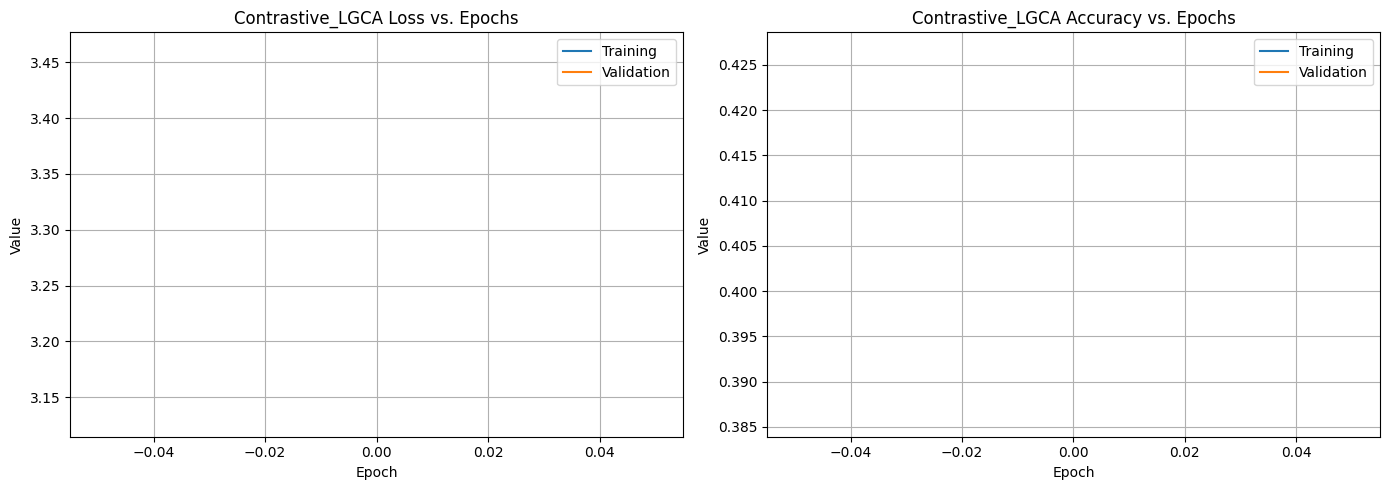

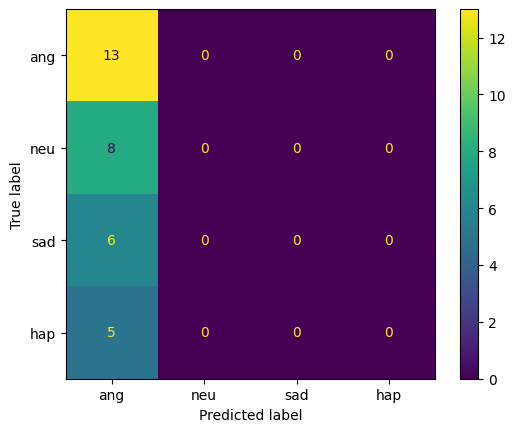

In [2]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Subset # 确保导入 Subset


from core.config import CONFIG, device
from scripts.tuning import run_hyperparameter_trial
from dataloaders.dataset import EmotionDataset
from contrastive.collator import ContrastiveDataCollator
from contrastive.model import ContrastiveModel
from contrastive.trainer import ContrastiveTrainer
from scripts.get_dataloaders import get_contrastive_dataloaders # 我们将复用它的部分逻辑

"""
层次一：冒烟测试。
只用一个批次的数据训练一个周期，检查代码能否跑通。
"""
print("\n========== [层次一：冒-烟-测-试] ==========")

# 1. 加载配置
CONFIG.load_config("config.yaml")

# 2. 准备一个“微型”数据集
print("准备微型数据集中...")
# 先获取完整的数据加载器，以便从中提取数据
full_dataloaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
full_train_dataset = full_dataloaders['train'].dataset

# 创建一个只包含32个样本的子集
micro_dataset = Subset(full_train_dataset, indices=range(32))

# 创建微型数据加载器
# 注意：这里的 collate_fn 需要从完整加载器中获取
micro_loader = DataLoader(
    micro_dataset,
    batch_size=CONFIG.dataloader_dict()['batch_size'],
    collate_fn=full_dataloaders['train'].collate_fn
)

# 3. 临时修改配置，只训练1个周期
class TempConfig(CONFIG):
    @classmethod
    def training_epochs(cls):
        return 1 # 只训练1轮
        
# 4. 调用函数进行测试
try:
    # 对于冒烟测试，训练集和验证集可以使用同一个微型加载器
    uar, war = run_hyperparameter_trial(
        alpha_value=0.5,
        train_loader=micro_loader,
        validation_loader=micro_loader,
        config=TempConfig
    )
    print("\n[成功] ✅ 冒烟测试通过！函数成功执行并返回了结果。")
    print(f"返回的指标: UAR={uar}, WAR={war}")
    
except Exception as e:
    print(f"\n[失败] ❌ 冒烟测试失败！代码在执行过程中崩溃。")
    print(f"错误信息: {e}")


## 有效性测试
end to end validation
- 观察训练过程中的loss是否在**稳步下降**。
- 检查函数结束时返回的`uar`和`war`是否是合理的浮点数值（例如，在0和1之间）。
- 检查调用它的主循环是否能正确接收这两个值并打印或记录下来。

In [ ]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Subset # 确保导入 Subset


from core.config import CONFIG, device
from scripts.tuning import run_hyperparameter_trial
from dataloaders.dataset import EmotionDataset
from contrastive.collator import ContrastiveDataCollator
from contrastive.model import ContrastiveModel
from contrastive.trainer import ContrastiveTrainer
from scripts.get_dataloaders import get_contrastive_dataloaders 
"""
层次二：端到端有效性验证。
使用完整数据，训练少量周期，验证loss下降且指标能被正确记录。
"""
print("\n========== [层次二：端-到-端-有-效-性-验-证] ==========")

# 1. 加载配置和完整数据集
CONFIG.load_config("config.yaml")
dataloaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
train_loader = dataloaders['train']
validation_loader = dataloaders['validation']

# # 2. 临时修改配置，只训练2个周期
# class TempConfig(CONFIG):
#     @classmethod
#     def training_epochs(cls):
#         return 3 # 训练2轮，足以观察趋势

# 3. 运行单次试验
try:
    # 用一个固定的alpha值进行测试
    alpha_to_test = 0.5
    uar, war = run_hyperparameter_trial(
        alpha_value=alpha_to_test,
        train_loader=train_loader,
        validation_loader=validation_loader,
        config=CONFIG,
        num_epochs=3,
        gradient_accumulation_steps=1
    )
    
    print("\n[成功] ✅ 端到端测试通过！")
    
    # 4. 断言检查结果的有效性
    assert isinstance(uar, float) and 0 <= uar <= 1, "UAR必须是0到1之间的浮点数"
    assert isinstance(war, float) and 0 <= war <= 1, "WAR必须是0到1之间的浮点数"
    print(f"返回的指标类型和范围正确: UAR={uar:.4f}, WAR={war:.4f}")
    
    # 5. 模拟日志记录
    results_df = pd.DataFrame([{'alpha': alpha_to_test, 'uar': uar, 'war': war}])
    print("日志记录模拟成功，数据如下:")
    print(results_df)

except Exception as e:
    print(f"\n[失败] ❌ 端到端测试失败！")
    print(f"错误信息: {e}")


========== [层次二：端-到-端-有-效-性-验-证] ==========
--- 正在为 'IEMOCAP' 准备双模态 Dataloaders ---
[INFO] 已从 E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl 加载原始数据信息。
[INFO] 音频和文本处理器初始化完成。

--- [试验开始] Alpha: 0.5 ---
[INFO] 使用梯度累积步数: 1, 损失权重 alpha: 0.5
开始训练...


Epoch 1 [训练中]:   0%|          | 0/1796 [00:06<?, ?it/s, acc=0, ce=1.43, loss=5.58, sup_con=8.3]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000021614BDA980>
Traceback (most recent call last):
  File "e:\Unitec\SER\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "e:\Unitec\SER\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Epoch 1 [训练中]:   2%|▏         | 32/1796 [00:54<48:32,  1.65s/it, acc=0.5, ce=1.26, loss=2.07, sup_con=1.63]  

## 过拟合测试
overfit test
- 训练损失（Training Loss）应该**持续、显著地下降**，最终趋近于0。
- 训练准确率（Training Accuracy/UAR）应该**稳步上升**，最终达到**100%或非常接近100%**。

e:\Unitec\SER\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



========== [层次三：过-拟-合-测-试] ==========
--- 正在为 'IEMOCAP' 准备双模态 Dataloaders ---
[INFO] 已从 E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl 加载原始数据信息。
[INFO] 音频和文本处理器初始化完成。
label of this batch:tensor([3, 0])
准备单个批次数据完成，批次大小: 2

--- [试验开始] Alpha: 0.5 ---
[INFO] 使用梯度累积步数: 1, 损失权重 alpha: 0.5
开始训练...


Epoch 100 [训练中]: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s, acc=1, ce=0.216, loss=0.218, sup_con=0.0023]


训练完成。
在IEMOCAP验证集上进行评估...


Evaluating the model: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]

Accuracy (WAR): 1.0000
UAR: 1.0000
试验完成: alpha=0.5, UAR=1.0000, WAR=1.0000

[成功] ✅ 过拟合测试执行完毕。
最终准确率 (WAR) = 1.0000，模型成功过拟合，具备有效学习能力！


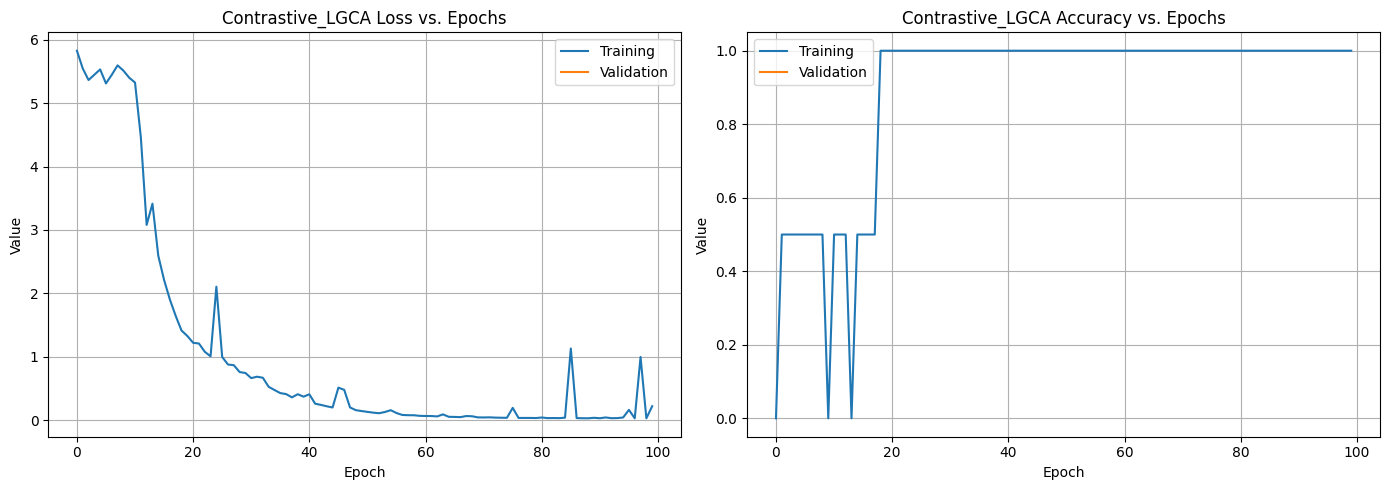

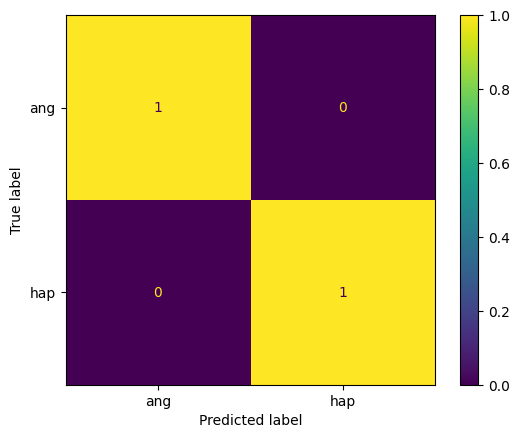

In [1]:
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader, Subset # 确保导入 Subset


from core.config import CONFIG, device
from scripts.tuning import run_hyperparameter_trial
from dataloaders.dataset import EmotionDataset
from contrastive.collator import ContrastiveDataCollator
from contrastive.model import ContrastiveModel
from contrastive.trainer import ContrastiveTrainer
from scripts.get_dataloaders import get_contrastive_dataloaders 
"""
层次三：过拟合测试。
在单个批次上进行多轮训练，验证模型学习能力。
"""
print("\n========== [层次三：过-拟-合-测-试] ==========")

# 1. 加载配置并准备一个“单批次”数据集
CONFIG.load_config("config.yaml")
full_dataloaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())

# 从完整训练集中取出一个批次的数据
single_batch = next(iter(full_dataloaders['train']))
print(f"label of this batch:{single_batch['labels']}")

# 将这个单批次数据包装成一个“伪”加载器
# 这样，每个epoch的训练和验证都只使用这一个批次
mini_loader = [single_batch] 

print(f"准备单个批次数据完成，批次大小: {len(single_batch['labels'])}")

# # 2. 临时修改配置，进行多轮训练
# class TempConfig(CONFIG):
#     @classmethod
#     def training_epochs(cls):
#         return 100 # 进行足够多的轮次以达到过拟合

# 3. 运行过拟合试验
try:
    final_uar, final_war = run_hyperparameter_trial(
        alpha_value=0.5,
        train_loader=mini_loader,
        validation_loader=mini_loader, # 训练和验证都用同一个批次
        config=CONFIG,
        num_epochs=100, # 进行足够多的轮次
        gradient_accumulation_steps=1 # <-- 关键修正：强制设为1，确保权重更新
    )
    
    print("\n[成功] ✅ 过拟合测试执行完毕。")
    
    # 4. 验证是否达到了过拟合标准
    # 对于过拟合测试，WAR（准确率）是更直观的指标
    assert final_war > 0.98, f"过拟合失败！最终准确率 {final_war:.4f} 未达到98%以上。"
    print(f"最终准确率 (WAR) = {final_war:.4f}，模型成功过拟合，具备有效学习能力！")

except Exception as e:
    print(f"\n[失败] ❌ 过拟合测试失败！")
    print(f"错误信息: {e}")

# 超参数alpha网格搜索

## [0.1, 0.5, 1.0, 2.0, 5.0]

### [0.1, 0.5]

e:\Unitec\SER\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- [阶段一：初始化] ---
实验结果将实时保存在: E:/Unitec/SER/audio\alpha_tuning_results_01-5.csv
base_size := 4

--- [阶段二：预加载数据集] ---
--- 正在为 'IEMOCAP' 准备双模态 Dataloaders ---
[INFO] 已从 E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl 加载原始数据信息。
[INFO] 音频和文本处理器初始化完成。

--- [阶段三：开始alpha网格搜索循环] ---

--- [试验开始] Alpha: 0.1 ---
--- [修改] 正在冻结 WavLM 的 CNN Feature Extractor ---
--- [修改] 正在冻结 DeBERTa 的 Embeddings ---
--- [修改] 正在冻结 DeBERTa 的 Encoder 前 6 层 ---
--- 编码器冻结操作完成 ---
--- [优化器配置] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] 使用梯度累积步数: 1, 损失权重 alpha: 0.1
开始训练...


Epoch 15 [验证中]: 100%|██████████| 225/225 [00:50<00:00,  4.45it/s]


训练完成。
在IEMOCAP验证集上进行评估...


Evaluating the model: 100%|██████████| 225/225 [00:48<00:00,  4.61it/s]


Accuracy (WAR): 0.7984
UAR: 0.7782
试验完成: alpha=0.1, UAR=0.7782, WAR=0.7984
--- Alpha = 0.1 的试验完成。结果已更新至CSV文件。 ---

--- [试验开始] Alpha: 0.5 ---
--- [修改] 正在冻结 WavLM 的 CNN Feature Extractor ---
--- [修改] 正在冻结 DeBERTa 的 Embeddings ---
--- [修改] 正在冻结 DeBERTa 的 Encoder 前 6 层 ---
--- 编码器冻结操作完成 ---
--- [优化器配置] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] 使用梯度累积步数: 1, 损失权重 alpha: 0.5
开始训练...


Epoch 15 [验证中]: 100%|██████████| 225/225 [10:26<00:00,  2.78s/it]


训练完成。
在IEMOCAP验证集上进行评估...


Evaluating the model: 100%|██████████| 225/225 [10:39<00:00,  2.84s/it]

Accuracy (WAR): 0.8062
UAR: 0.7777
试验完成: alpha=0.5, UAR=0.7777, WAR=0.8062
--- Alpha = 0.5 的试验完成。结果已更新至CSV文件。 ---

--- [阶段四：所有试验完成] ---
最终的超参数搜索结果:
   alpha  validation_uar  validation_war
0    0.1        0.778225        0.798441
1    0.5        0.777700        0.806236


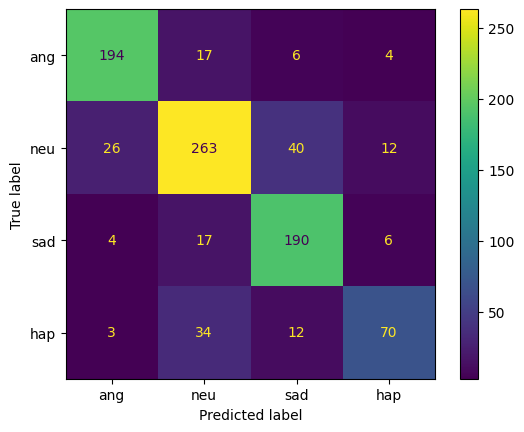

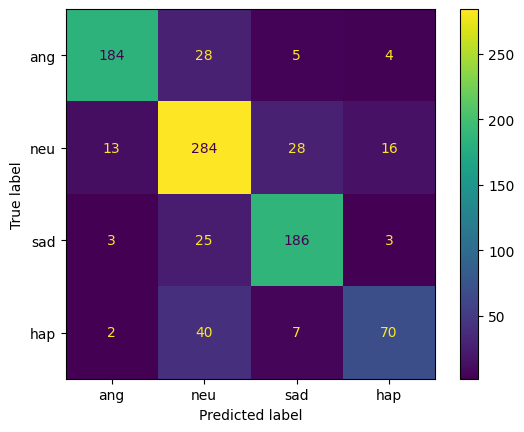

In [1]:
# main_tuning.py

import torch
import pandas as pd
import os
import gc

# 从您的模块中导入所需的工具
from core.config import CONFIG
from scripts.get_dataloaders import get_contrastive_dataloaders
from scripts.tuning import run_hyperparameter_trial # <-- 从您的工具箱导入函数

# def main_tuning_loop():
"""
执行完整的超参数alpha网格搜索的主函数。
"""
# (这里的代码就是我上一条回复中提供给您的主循环代码)
print("--- [阶段一：初始化] ---")
CONFIG.load_config("config.yaml")

# alpha_values_to_test = [0.1, 0.5, 1.0, 2.0, 5.0]
alpha_values_to_test = [0.1, 0.5]
results_list = []
results_filepath = os.path.join(CONFIG.project_root(), "alpha_tuning_results_01-5.csv")
print(f"实验结果将实时保存在: {results_filepath}")
print(f"base_size := {CONFIG.dataloader_dict()['batch_size']}")
print("\n--- [阶段二：预加载数据集] ---")
dataloaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
train_loader = dataloaders['train']
validation_loader = dataloaders['validation']

print("\n--- [阶段三：开始alpha网格搜索循环] ---")
for alpha in alpha_values_to_test:
    torch.cuda.empty_cache()
    gc.collect()
    
    try:
        val_uar, val_war = run_hyperparameter_trial(
            alpha_value=alpha,
            train_loader=train_loader,
            validation_loader=validation_loader,
            config=CONFIG,
            num_epochs=CONFIG.training_epochs(),
            gradient_accumulation_steps=1
        )
        result_entry = {'alpha': alpha, 'validation_uar': val_uar, 'validation_war': val_war}
    except Exception as e:
        print(f"警告：alpha = {alpha} 的试验因错误而失败: {e}")
        result_entry = {'alpha': alpha, 'validation_uar': "Failed", 'validation_war': "Failed"}

    results_list.append(result_entry)
    results_df = pd.DataFrame(results_list)
    results_df.to_csv(results_filepath, index=False)
    print(f"--- Alpha = {alpha} 的试验完成。结果已更新至CSV文件。 ---")

print("\n--- [阶段四：所有试验完成] ---")
print("最终的超参数搜索结果:")
final_results = pd.read_csv(results_filepath)
print(final_results)

# # --- 脚本执行入口 ---
# if __name__ == '__main__':
#     main_tuning_loop()

### [0.1]

In [3]:
# main_tuning.py

import torch
import pandas as pd
import os
import gc

# 从您的模块中导入所需的工具
from core.config import CONFIG
from scripts.get_dataloaders import get_contrastive_dataloaders
from scripts.tuning import run_hyperparameter_trial # <-- 从您的工具箱导入函数
from contrastive.model import setup_memory_optimization

setup_memory_optimization()


print("--- [阶段一：初始化] ---")
CONFIG.load_config("config.yaml")

# alpha_values_to_test = [0.1, 0.5, 1.0, 2.0, 5.0]
alpha_values_to_test = [1.0]
results_list = []
results_filepath = os.path.join(CONFIG.save_tables_location(), "alpha_tuning_results_0.1.csv")
print(f"实验结果将实时保存在: {results_filepath}")
print(f"base_size := {CONFIG.dataloader_dict()['batch_size']}")
print("\n--- [阶段二：预加载数据集] ---")
dataloaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
train_loader = dataloaders['train']
validation_loader = dataloaders['validation']

print("\n--- [阶段三：开始alpha网格搜索循环] ---")
for alpha in alpha_values_to_test:
    torch.cuda.empty_cache()
    gc.collect()
    
    try:
        val_uar, val_war = run_hyperparameter_trial(
            alpha_value=alpha,
            train_loader=train_loader,
            validation_loader=validation_loader,
            config=CONFIG,
            num_epochs=CONFIG.training_epochs(),
            gradient_accumulation_steps=1
        )
        result_entry = {'alpha': alpha, 'validation_uar': val_uar, 'validation_war': val_war}
    except Exception as e:
        print(f"警告：alpha = {alpha} 的试验因错误而失败: {e}")
        result_entry = {'alpha': alpha, 'validation_uar': "Failed", 'validation_war': "Failed"}

    results_list.append(result_entry)
    results_df = pd.DataFrame(results_list)
    results_df.to_csv(results_filepath, index=False)
    print(f"--- Alpha = {alpha} 的试验完成。结果已更新至CSV文件。 ---")

print("\n--- [阶段四：所有试验完成] ---")
print("最终的超参数搜索结果:")
final_results = pd.read_csv(results_filepath)
print(final_results)


GPU总内存: 8.59 GB
内存优化设置完成
--- [阶段一：初始化] ---
实验结果将实时保存在: E:/Unitec/SER/audio\tables\alpha_tuning_results_0.1.csv
base_size := 4

--- [阶段二：预加载数据集] ---
--- 正在为 'IEMOCAP' 准备双模态 Dataloaders ---
[INFO] 已从 E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl 加载原始数据信息。
[INFO] 音频和文本处理器初始化完成。

--- [阶段三：开始alpha网格搜索循环] ---

--- [试验开始] Alpha: 1.0 ---
--- 正在冻结 WavLM 的 CNN Feature Extractor ---
--- 正在冻结 DeBERTa 的 Embeddings ---
--- 正在冻结 DeBERTa 的 Encoder 前 6 层 ---
--- 编码器冻结操作完成 ---
--- [优化器配置] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] 使用梯度累积步数: 1, 损失权重 alpha: 1.0
开始训练...


Epoch 1 [训练中]:  22%|██▏       | 200/898 [01:49<06:21,  1.83it/s, acc=0.5, ce=1.34, loss=3.12, sup_con=1.78]  


KeyboardInterrupt: 

### 增加梯度检查点

In [2]:
# main_tuning.py

import torch
import pandas as pd
import os
import gc

# 从您的模块中导入所需的工具
from core.config import CONFIG
from scripts.get_dataloaders import get_contrastive_dataloaders
from scripts.tuning import run_hyperparameter_trial # <-- 从您的工具箱导入函数
from contrastive.model import setup_memory_optimization

setup_memory_optimization()


print("--- [阶段一：初始化] ---")
CONFIG.load_config("config.yaml")

# alpha_values_to_test = [0.1, 0.5, 1.0, 2.0, 5.0]
alpha_values_to_test = [0.1]
results_list = []
results_filepath = os.path.join(CONFIG.save_tables_location(), "alpha_tuning_results_0.1.csv")
print(f"实验结果将实时保存在: {results_filepath}")
print(f"base_size := {CONFIG.dataloader_dict()['batch_size']}")
print("\n--- [阶段二：预加载数据集] ---")
dataloaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
train_loader = dataloaders['train']
validation_loader = dataloaders['validation']

print("\n--- [阶段三：开始alpha网格搜索循环] ---")
for alpha in alpha_values_to_test:
    torch.cuda.empty_cache()
    gc.collect()
    
    try:
        val_uar, val_war = run_hyperparameter_trial(
            alpha_value=alpha,
            train_loader=train_loader,
            validation_loader=validation_loader,
            config=CONFIG,
            num_epochs=CONFIG.training_epochs(),
            gradient_accumulation_steps=1
        )
        result_entry = {'alpha': alpha, 'validation_uar': val_uar, 'validation_war': val_war}
    except Exception as e:
        print(f"警告：alpha = {alpha} 的试验因错误而失败: {e}")
        result_entry = {'alpha': alpha, 'validation_uar': "Failed", 'validation_war': "Failed"}

    results_list.append(result_entry)
    results_df = pd.DataFrame(results_list)
    results_df.to_csv(results_filepath, index=False)
    print(f"--- Alpha = {alpha} 的试验完成。结果已更新至CSV文件。 ---")

print("\n--- [阶段四：所有试验完成] ---")
print("最终的超参数搜索结果:")
final_results = pd.read_csv(results_filepath)
print(final_results)


GPU总内存: 8.59 GB
内存优化设置完成
--- [阶段一：初始化] ---
实验结果将实时保存在: E:/Unitec/SER/audio\tables\alpha_tuning_results_0.1.csv
base_size := 4

--- [阶段二：预加载数据集] ---
--- 正在为 'IEMOCAP' 准备双模态 Dataloaders ---
[INFO] 已从 E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl 加载原始数据信息。
[INFO] 音频和文本处理器初始化完成。

--- [阶段三：开始alpha网格搜索循环] ---

--- [试验开始] Alpha: 0.1 ---
--- 正在冻结 WavLM 的 CNN Feature Extractor ---
--- 正在冻结 DeBERTa 的 Embeddings ---
--- 正在冻结 DeBERTa 的 Encoder 前 6 层 ---
--- 编码器冻结操作完成 ---
--- [优化器配置] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] 使用梯度累积步数: 1, 损失权重 alpha: 0.1
开始训练...


Epoch 4 [训练中]:  97%|█████████▋| 871/898 [09:20<00:17,  1.55it/s, acc=1, ce=0.17, loss=0.356, sup_con=1.86]    


KeyboardInterrupt: 

### 1.0
所有音频都识别成了neu, 为什么会是这样的结果？
Accuracy (WAR): 0.3797
UAR: 0.2500

e:\Unitec\SER\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU总内存: 8.59 GB
内存优化设置完成
--- [阶段一：初始化] ---
实验结果将实时保存在: E:/Unitec/SER/audio\tables\alpha_tuning_results_1.csv
base_size := 4

--- [阶段二：预加载数据集] ---
--- 正在为 'IEMOCAP' 准备双模态 Dataloaders ---
[INFO] 已从 E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl 加载原始数据信息。
[INFO] 音频和文本处理器初始化完成。

--- [阶段三：开始alpha网格搜索循环] ---

--- [试验开始] Alpha: 1.0 ---
--- 正在冻结 WavLM 的 CNN Feature Extractor ---
--- 正在冻结 DeBERTa 的 Embeddings ---
--- 正在冻结 DeBERTa 的 Encoder 前 6 层 ---
--- 编码器冻结操作完成 ---
--- [优化器配置] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] 使用梯度累积步数: 2, 损失权重 alpha: 1.0
开始训练...


Epoch 15 [验证中]: 100%|██████████| 225/225 [00:53<00:00,  4.24it/s]


训练完成。
在IEMOCAP验证集上进行评估...


Evaluating the model: 100%|██████████| 225/225 [01:35<00:00,  2.36it/s]


Accuracy (WAR): 0.7973
UAR: 0.7793
试验完成: alpha=1.0, UAR=0.7793, WAR=0.7973
--- Alpha = 1.0 的试验完成。结果已更新至CSV文件。 ---

--- [阶段四：所有试验完成] ---
最终的超参数搜索结果:
   alpha  validation_uar  validation_war
0    1.0        0.779297        0.797327


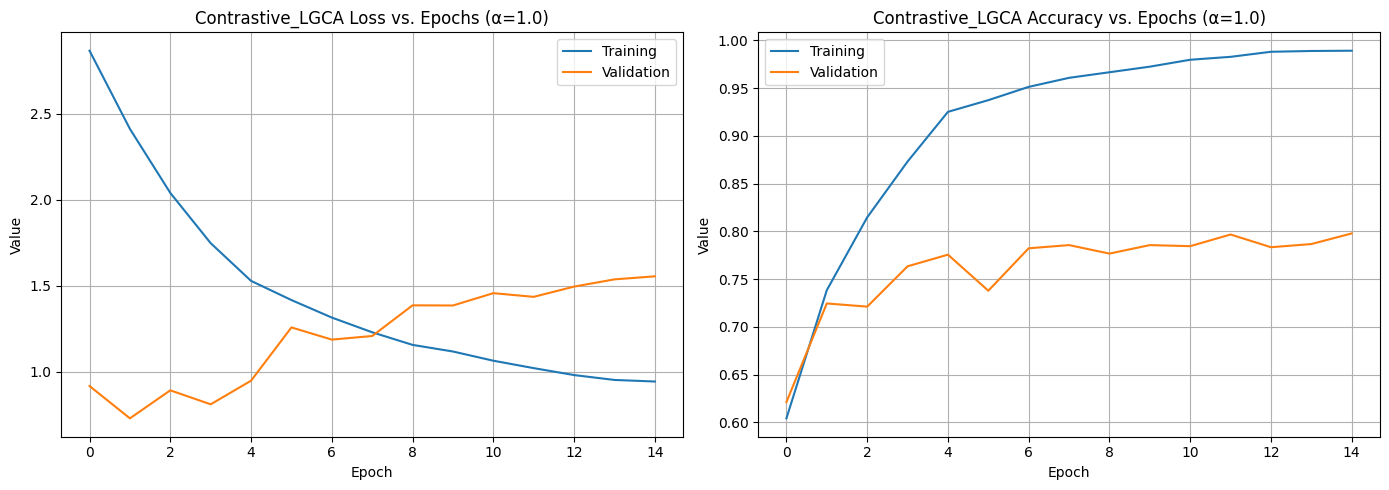

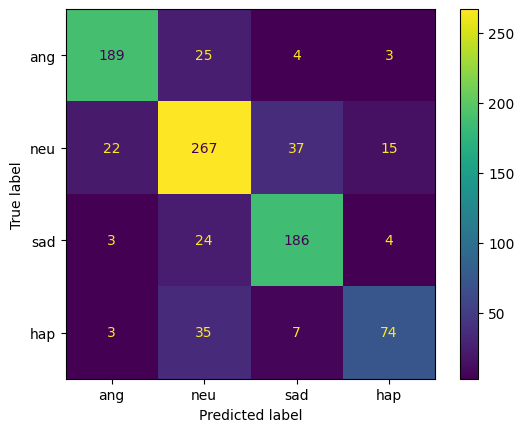

In [1]:
# main_tuning.py

import torch
import pandas as pd
import os
import gc

# 从您的模块中导入所需的工具
from core.config import CONFIG
from scripts.get_dataloaders import get_contrastive_dataloaders
from scripts.tuning import run_hyperparameter_trial # <-- 从您的工具箱导入函数
from contrastive.model import setup_memory_optimization

setup_memory_optimization()

# def main_tuning_loop():
"""
执行完整的超参数alpha网格搜索的主函数。
"""
# (这里的代码就是我上一条回复中提供给您的主循环代码)
print("--- [阶段一：初始化] ---")
CONFIG.load_config("config.yaml")

# alpha_values_to_test = [0.1, 0.5, 1.0, 2.0, 5.0]
alpha_values_to_test = [1.0]
results_list = []
results_filepath = os.path.join(CONFIG.save_tables_location(), "alpha_tuning_results_1.csv")
print(f"实验结果将实时保存在: {results_filepath}")
print(f"base_size := {CONFIG.dataloader_dict()['batch_size']}")
print("\n--- [阶段二：预加载数据集] ---")
dataloaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
train_loader = dataloaders['train']
validation_loader = dataloaders['validation']

print("\n--- [阶段三：开始alpha网格搜索循环] ---")
for alpha in alpha_values_to_test:
    torch.cuda.empty_cache()
    gc.collect()
    
    try:
        val_uar, val_war = run_hyperparameter_trial(
            alpha_value=alpha,
            train_loader=train_loader,
            validation_loader=validation_loader,
            config=CONFIG,
            num_epochs=CONFIG.training_epochs(),
            gradient_accumulation_steps=2
        )
        result_entry = {'alpha': alpha, 'validation_uar': val_uar, 'validation_war': val_war}
    except Exception as e:
        print(f"警告：alpha = {alpha} 的试验因错误而失败: {e}")
        result_entry = {'alpha': alpha, 'validation_uar': "Failed", 'validation_war': "Failed"}

    results_list.append(result_entry)
    results_df = pd.DataFrame(results_list)
    results_df.to_csv(results_filepath, index=False)
    print(f"--- Alpha = {alpha} 的试验完成。结果已更新至CSV文件。 ---")

print("\n--- [阶段四：所有试验完成] ---")
print("最终的超参数搜索结果:")
final_results = pd.read_csv(results_filepath)
print(final_results)

# # --- 脚本执行入口 ---
# if __name__ == '__main__':
#     main_tuning_loop()

--- [阶段一：初始化] ---
实验结果将实时保存在: E:/Unitec/SER/audio\alpha_tuning_results_1-5.csv
base_size := 4

--- [阶段二：预加载数据集] ---
--- 正在为 'IEMOCAP' 准备双模态 Dataloaders ---
[INFO] 已从 E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl 加载原始数据信息。
[INFO] 音频和文本处理器初始化完成。

--- [阶段三：开始alpha网格搜索循环] ---

--- [试验开始] Alpha: 1.0 ---
--- [修改] 正在冻结 WavLM 的 CNN Feature Extractor ---
--- [修改] 正在冻结 DeBERTa 的 Embeddings ---
--- [修改] 正在冻结 DeBERTa 的 Encoder 前 6 层 ---
--- 编码器冻结操作完成 ---
--- [优化器配置] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] 使用梯度累积步数: 1, 损失权重 alpha: 1.0
开始训练...


Epoch 15 [验证中]: 100%|██████████| 225/225 [02:38<00:00,  1.42it/s]


训练完成。
在IEMOCAP验证集上进行评估...


Evaluating the model: 100%|██████████| 225/225 [02:37<00:00,  1.43it/s]


Accuracy (WAR): 0.3797
UAR: 0.2500
试验完成: alpha=1.0, UAR=0.2500, WAR=0.3797
--- Alpha = 1.0 的试验完成。结果已更新至CSV文件。 ---

--- [试验开始] Alpha: 2.0 ---
--- [修改] 正在冻结 WavLM 的 CNN Feature Extractor ---
--- [修改] 正在冻结 DeBERTa 的 Embeddings ---
--- [修改] 正在冻结 DeBERTa 的 Encoder 前 6 层 ---
--- 编码器冻结操作完成 ---
--- [优化器配置] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] 使用梯度累积步数: 1, 损失权重 alpha: 2.0
开始训练...


Epoch 14 [验证中]:  64%|██████▎   | 143/225 [00:36<00:21,  3.90it/s]

警告：alpha = 2.0 的试验因错误而失败: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

--- Alpha = 2.0 的试验完成。结果已更新至CSV文件。 ---


RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


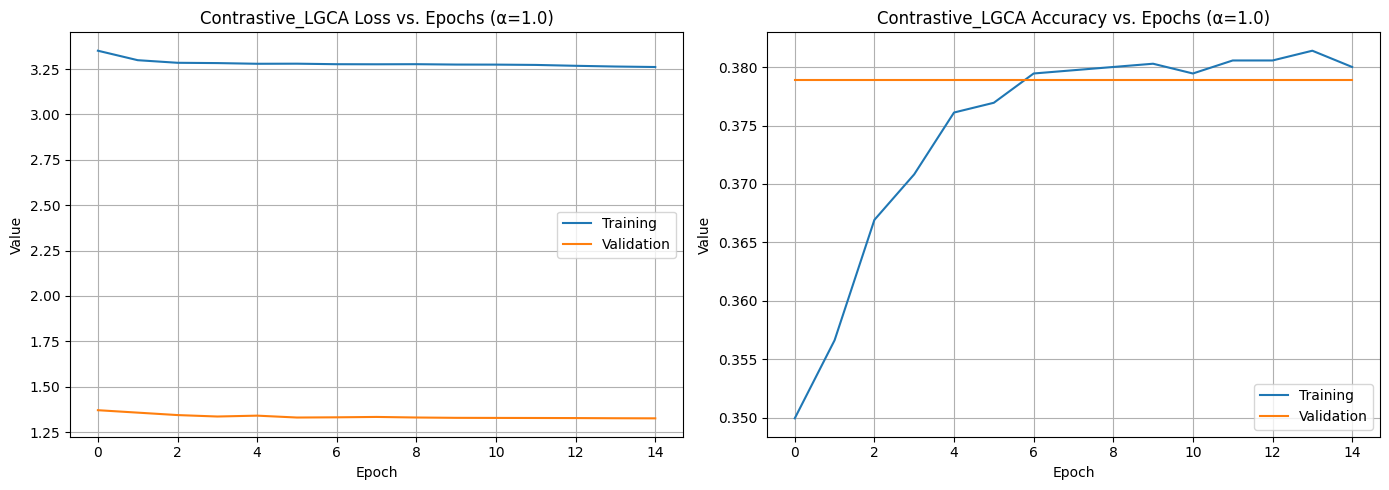

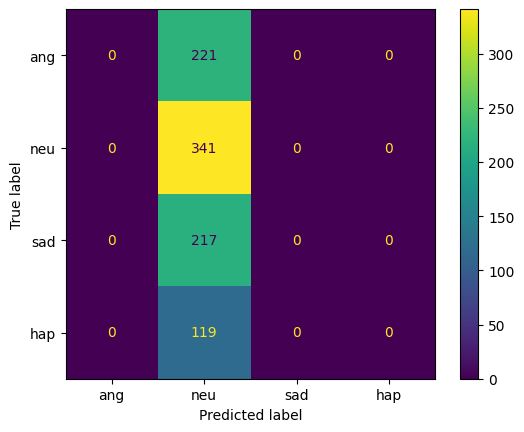

In [ ]:
# main_tuning.py

import torch
import pandas as pd
import os
import gc

# 从您的模块中导入所需的工具
from core.config import CONFIG
from scripts.get_dataloaders import get_contrastive_dataloaders
from scripts.tuning import run_hyperparameter_trial # <-- 从您的工具箱导入函数

# def main_tuning_loop():
"""
执行完整的超参数alpha网格搜索的主函数。
"""
# (这里的代码就是我上一条回复中提供给您的主循环代码)
print("--- [阶段一：初始化] ---")
CONFIG.load_config("config.yaml")

# alpha_values_to_test = [0.1, 0.5, 1.0, 2.0, 5.0]
alpha_values_to_test = [1.0, 2.0, 5.0]
results_list = []
results_filepath = os.path.join(CONFIG.project_root(), "alpha_tuning_results_1-5.csv")
print(f"实验结果将实时保存在: {results_filepath}")
print(f"base_size := {CONFIG.dataloader_dict()['batch_size']}")
print("\n--- [阶段二：预加载数据集] ---")
dataloaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
train_loader = dataloaders['train']
validation_loader = dataloaders['validation']

print("\n--- [阶段三：开始alpha网格搜索循环] ---")
for alpha in alpha_values_to_test:
    torch.cuda.empty_cache()
    gc.collect()
    
    try:
        val_uar, val_war = run_hyperparameter_trial(
            alpha_value=alpha,
            train_loader=train_loader,
            validation_loader=validation_loader,
            config=CONFIG,
            num_epochs=CONFIG.training_epochs(),
            gradient_accumulation_steps=1
        )
        result_entry = {'alpha': alpha, 'validation_uar': val_uar, 'validation_war': val_war}
    except Exception as e:
        print(f"警告：alpha = {alpha} 的试验因错误而失败: {e}")
        result_entry = {'alpha': alpha, 'validation_uar': "Failed", 'validation_war': "Failed"}

    results_list.append(result_entry)
    results_df = pd.DataFrame(results_list)
    results_df.to_csv(results_filepath, index=False)
    print(f"--- Alpha = {alpha} 的试验完成。结果已更新至CSV文件。 ---")

print("\n--- [阶段四：所有试验完成] ---")
print("最终的超参数搜索结果:")
final_results = pd.read_csv(results_filepath)
print(final_results)

# # --- 脚本执行入口 ---
# if __name__ == '__main__':
#     main_tuning_loop()

### [2.0, 5.0]

--- [阶段一：初始化] ---
实验结果将实时保存在: E:/Unitec/SER/audio\alpha_tuning_results_2-5.csv
base_size := 4

--- [阶段二：预加载数据集] ---
--- 正在为 'IEMOCAP' 准备双模态 Dataloaders ---
[INFO] 已从 E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl 加载原始数据信息。
[INFO] 音频和文本处理器初始化完成。

--- [阶段三：开始alpha网格搜索循环] ---

--- [试验开始] Alpha: 2.0 ---
--- [修改] 正在冻结 WavLM 的 CNN Feature Extractor ---
--- [修改] 正在冻结 DeBERTa 的 Embeddings ---
--- [修改] 正在冻结 DeBERTa 的 Encoder 前 6 层 ---
--- 编码器冻结操作完成 ---
--- [优化器配置] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] 使用梯度累积步数: 1, 损失权重 alpha: 2.0
开始训练...


Epoch 15 [验证中]: 100%|██████████| 225/225 [16:26<00:00,  4.38s/it]


训练完成。
在IEMOCAP验证集上进行评估...


Evaluating the model: 100%|██████████| 225/225 [16:46<00:00,  4.48s/it]


Accuracy (WAR): 0.8073
UAR: 0.7779
试验完成: alpha=2.0, UAR=0.7779, WAR=0.8073
--- Alpha = 2.0 的试验完成。结果已更新至CSV文件。 ---

--- [试验开始] Alpha: 5.0 ---
--- [修改] 正在冻结 WavLM 的 CNN Feature Extractor ---
--- [修改] 正在冻结 DeBERTa 的 Embeddings ---
--- [修改] 正在冻结 DeBERTa 的 Encoder 前 6 层 ---
--- 编码器冻结操作完成 ---
--- [优化器配置] Backbone LR: 5e-05, Head LR: 0.001 ---
[INFO] 使用梯度累积步数: 1, 损失权重 alpha: 5.0
开始训练...


Epoch 15 [验证中]: 100%|██████████| 225/225 [40:32<00:00, 10.81s/it] 


训练完成。
在IEMOCAP验证集上进行评估...


Evaluating the model: 100%|██████████| 225/225 [52:06<00:00, 13.90s/it]  

Accuracy (WAR): 0.7929
UAR: 0.7581
试验完成: alpha=5.0, UAR=0.7581, WAR=0.7929
--- Alpha = 5.0 的试验完成。结果已更新至CSV文件。 ---

--- [阶段四：所有试验完成] ---
最终的超参数搜索结果:
   alpha  validation_uar  validation_war
0    2.0        0.777880        0.807350
1    5.0        0.758123        0.792873


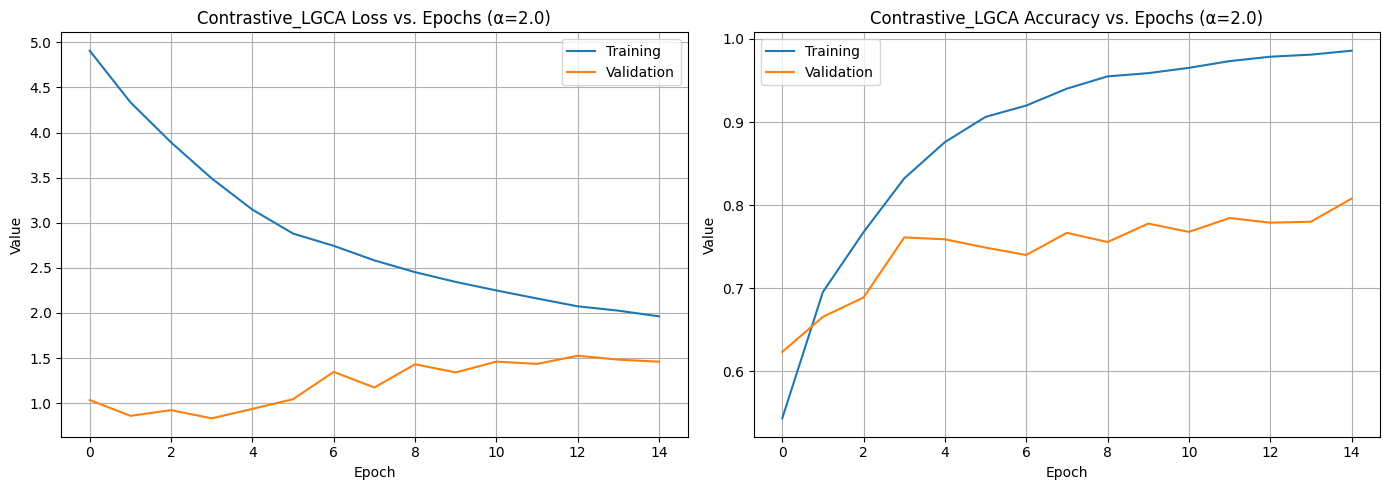

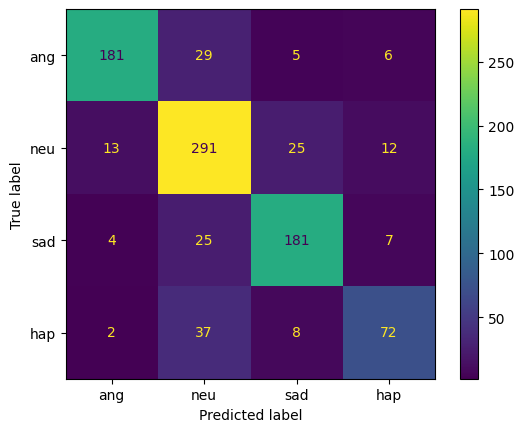

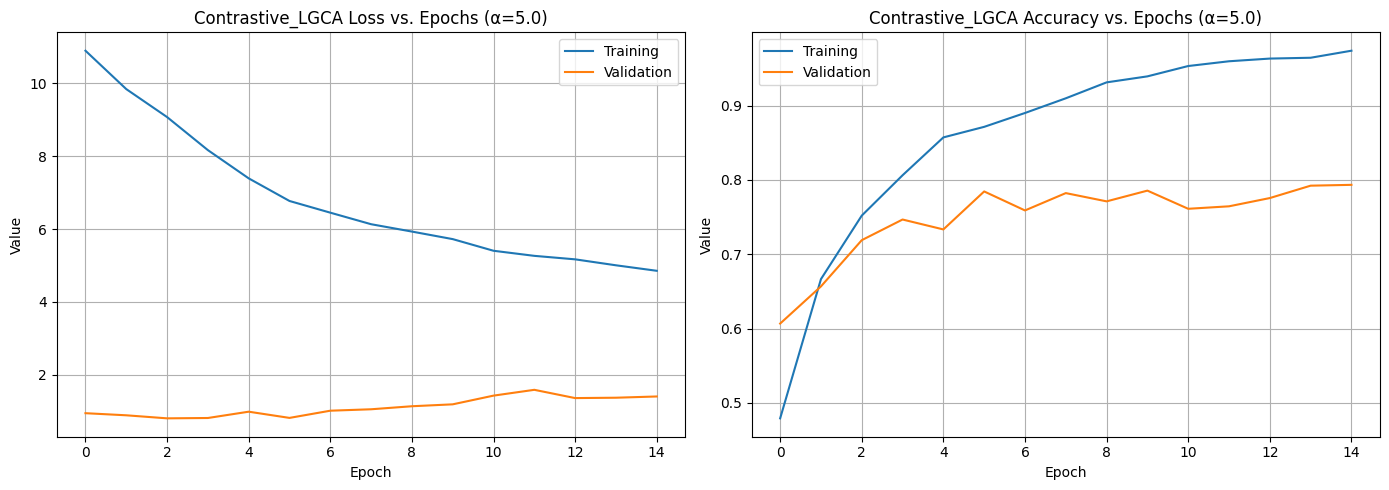

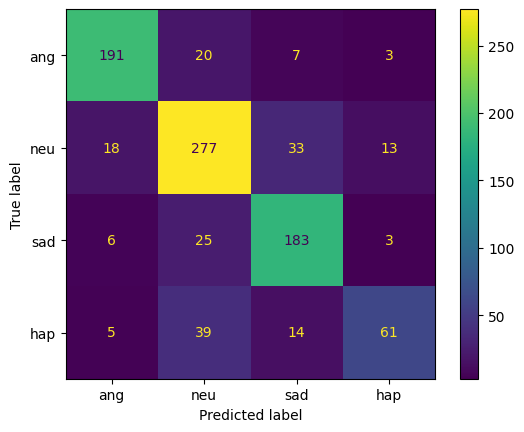

In [2]:
# main_tuning.py

import torch
import pandas as pd
import os
import gc

# 从您的模块中导入所需的工具
from core.config import CONFIG
from scripts.get_dataloaders import get_contrastive_dataloaders
from scripts.tuning import run_hyperparameter_trial # <-- 从您的工具箱导入函数

# def main_tuning_loop():
"""
执行完整的超参数alpha网格搜索的主函数。
"""
# (这里的代码就是我上一条回复中提供给您的主循环代码)
print("--- [阶段一：初始化] ---")
CONFIG.load_config("config.yaml")

# alpha_values_to_test = [0.1, 0.5, 1.0, 2.0, 5.0]
alpha_values_to_test = [2.0, 5.0]
results_list = []
results_filepath = os.path.join(CONFIG.project_root(), "alpha_tuning_results_2-5.csv")
print(f"实验结果将实时保存在: {results_filepath}")
print(f"base_size := {CONFIG.dataloader_dict()['batch_size']}")
print("\n--- [阶段二：预加载数据集] ---")
dataloaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
train_loader = dataloaders['train']
validation_loader = dataloaders['validation']

print("\n--- [阶段三：开始alpha网格搜索循环] ---")
for alpha in alpha_values_to_test:
    torch.cuda.empty_cache()
    gc.collect()
    
    try:
        val_uar, val_war = run_hyperparameter_trial(
            alpha_value=alpha,
            train_loader=train_loader,
            validation_loader=validation_loader,
            config=CONFIG,
            num_epochs=CONFIG.training_epochs(),
            gradient_accumulation_steps=1
        )
        result_entry = {'alpha': alpha, 'validation_uar': val_uar, 'validation_war': val_war}
    except Exception as e:
        print(f"警告：alpha = {alpha} 的试验因错误而失败: {e}")
        result_entry = {'alpha': alpha, 'validation_uar': "Failed", 'validation_war': "Failed"}

    results_list.append(result_entry)
    results_df = pd.DataFrame(results_list)
    results_df.to_csv(results_filepath, index=False)
    print(f"--- Alpha = {alpha} 的试验完成。结果已更新至CSV文件。 ---")

print("\n--- [阶段四：所有试验完成] ---")
print("最终的超参数搜索结果:")
final_results = pd.read_csv(results_filepath)
print(final_results)

# # --- 脚本执行入口 ---
# if __name__ == '__main__':
#     main_tuning_loop()

### 超参数alpha网格搜索 [2.0, 3.0, 4.0, 5.0, 6.0]

--- [阶段一：初始化] ---
实验结果将实时保存在: E:/Unitec/SER/audio\alpha_tuning_results_2-6.csv

--- [阶段二：预加载数据集] ---
--- 正在为 'IEMOCAP' 准备双模态 Dataloaders ---
[INFO] 已从 E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl 加载原始数据信息。


2025-09-04 12:03:08,437 - INFO - 已加载 'IEMOCAP' 数据集用于 'train' 划分。大小: 3592
已加载 'IEMOCAP' 数据集用于 'train' 划分。大小: 3592
2025-09-04 12:03:08,442 - INFO - 已加载 'IEMOCAP' 数据集用于 'validation' 划分。大小: 898
已加载 'IEMOCAP' 数据集用于 'validation' 划分。大小: 898


[INFO] 音频和文本处理器初始化完成。

--- [阶段三：开始alpha网格搜索循环] ---

--- [试验开始] Alpha: 2.0 ---


2025-09-04 12:03:13,161 - INFO - 开始训练 Contrastive_LGCA 模型...
开始训练 Contrastive_LGCA 模型...


[INFO] 使用梯度累积步数: 4, 损失权重 alpha: 2.0
开始训练...


Epoch 10 [训练中]: 100%|██████████| 1796/1796 [05:35<00:00,  5.35it/s, acc=1, ce=0.00758, loss=2.33, sup_con=1.16]     


训练完成。
在IEMOCAP验证集上进行评估...


Evaluating the model: 100%|██████████| 449/449 [00:26<00:00, 16.87it/s]


Accuracy (WAR): 0.7494
UAR: 0.7194
试验完成: alpha=2.0, UAR=0.7194, WAR=0.7494
--- Alpha = 2.0 的试验完成。结果已更新至CSV文件。 ---

--- [试验开始] Alpha: 3.0 ---


2025-09-04 13:02:45,888 - INFO - 开始训练 Contrastive_LGCA 模型...
开始训练 Contrastive_LGCA 模型...


[INFO] 使用梯度累积步数: 4, 损失权重 alpha: 3.0
开始训练...


Epoch 10 [训练中]: 100%|██████████| 1796/1796 [05:17<00:00,  5.66it/s, acc=1, ce=0.00747, loss=3.74, sup_con=1.24]     


训练完成。
在IEMOCAP验证集上进行评估...


Evaluating the model: 100%|██████████| 449/449 [00:26<00:00, 16.95it/s]


Accuracy (WAR): 0.7517
UAR: 0.7217
试验完成: alpha=3.0, UAR=0.7217, WAR=0.7517
--- Alpha = 3.0 的试验完成。结果已更新至CSV文件。 ---

--- [试验开始] Alpha: 4.0 ---


2025-09-04 13:56:23,191 - INFO - 开始训练 Contrastive_LGCA 模型...
开始训练 Contrastive_LGCA 模型...


[INFO] 使用梯度累积步数: 4, 损失权重 alpha: 4.0
开始训练...


Epoch 10 [训练中]: 100%|██████████| 1796/1796 [05:17<00:00,  5.66it/s, acc=1, ce=0.0443, loss=5.26, sup_con=1.3]       


训练完成。
在IEMOCAP验证集上进行评估...


Evaluating the model: 100%|██████████| 449/449 [00:26<00:00, 16.77it/s]


Accuracy (WAR): 0.7472
UAR: 0.7214
试验完成: alpha=4.0, UAR=0.7214, WAR=0.7472
--- Alpha = 4.0 的试验完成。结果已更新至CSV文件。 ---

--- [试验开始] Alpha: 5.0 ---


2025-09-04 14:49:42,732 - INFO - 开始训练 Contrastive_LGCA 模型...
开始训练 Contrastive_LGCA 模型...


[INFO] 使用梯度累积步数: 4, 损失权重 alpha: 5.0
开始训练...


Epoch 10 [训练中]: 100%|██████████| 1796/1796 [05:18<00:00,  5.63it/s, acc=1, ce=0.099, loss=6.56, sup_con=1.29]       


训练完成。
在IEMOCAP验证集上进行评估...


Evaluating the model: 100%|██████████| 449/449 [00:26<00:00, 16.67it/s]


Accuracy (WAR): 0.7183
UAR: 0.6796
试验完成: alpha=5.0, UAR=0.6796, WAR=0.7183
--- Alpha = 5.0 的试验完成。结果已更新至CSV文件。 ---

--- [试验开始] Alpha: 6.0 ---


2025-09-04 15:43:34,340 - INFO - 开始训练 Contrastive_LGCA 模型...
开始训练 Contrastive_LGCA 模型...


[INFO] 使用梯度累积步数: 4, 损失权重 alpha: 6.0
开始训练...


Epoch 10 [训练中]: 100%|██████████| 1796/1796 [05:18<00:00,  5.63it/s, acc=1, ce=0.234, loss=7.32, sup_con=1.18]       


训练完成。
在IEMOCAP验证集上进行评估...


Evaluating the model: 100%|██████████| 449/449 [00:26<00:00, 16.71it/s]

Accuracy (WAR): 0.7283
UAR: 0.6896
试验完成: alpha=6.0, UAR=0.6896, WAR=0.7283
--- Alpha = 6.0 的试验完成。结果已更新至CSV文件。 ---

--- [阶段四：所有试验完成] ---
最终的超参数搜索结果:
   alpha  validation_uar  validation_war
0    2.0        0.719352        0.749443
1    3.0        0.721708        0.751670
2    4.0        0.721418        0.747216
3    5.0        0.679608        0.718263
4    6.0        0.689585        0.728285


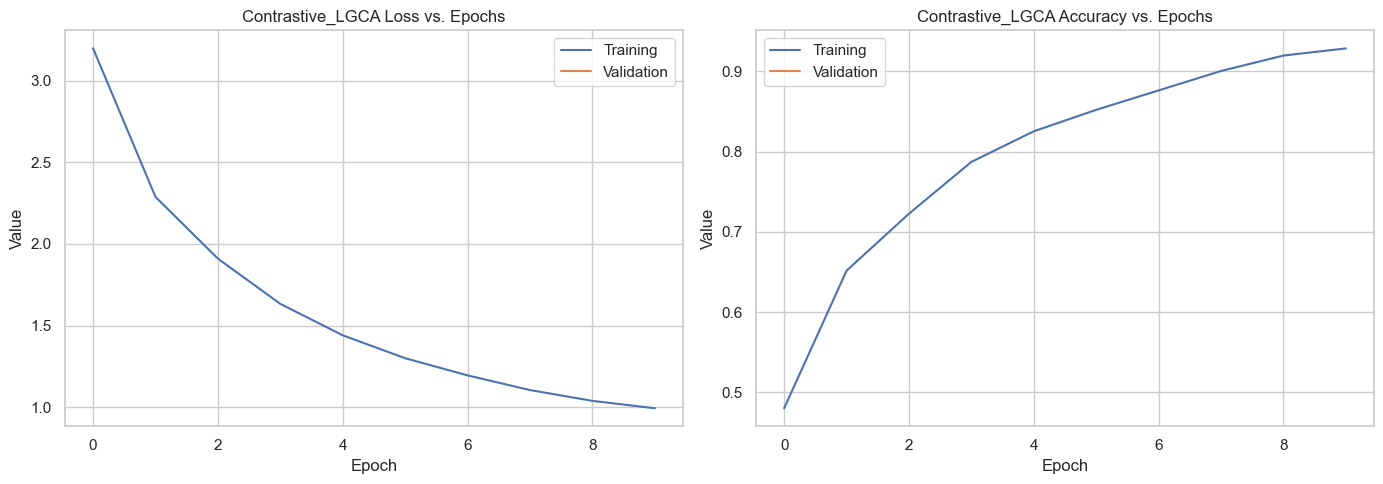

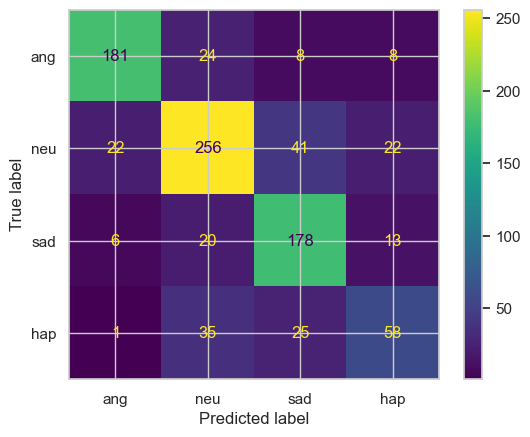

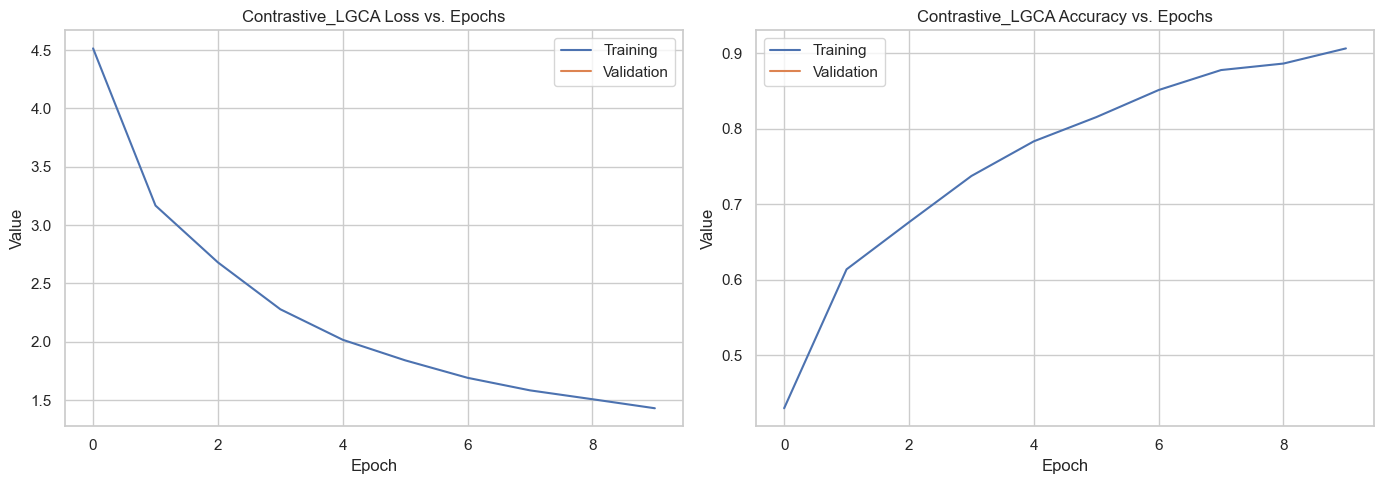

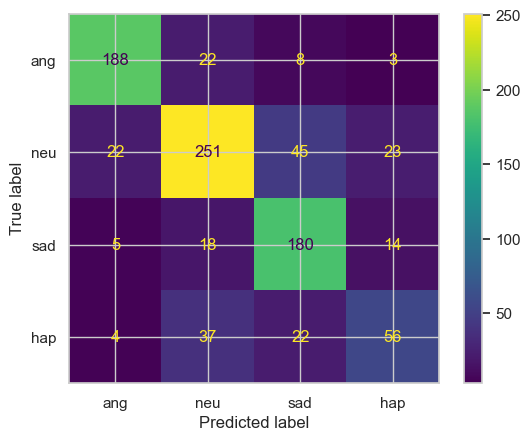

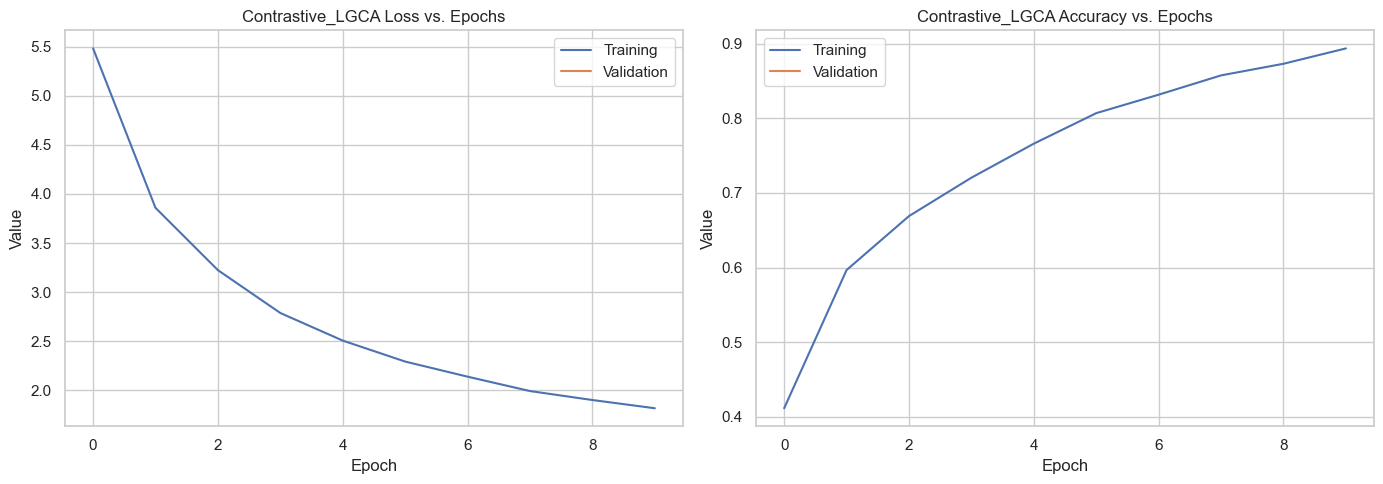

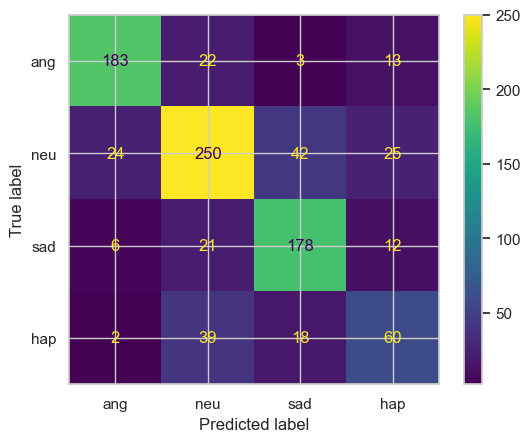

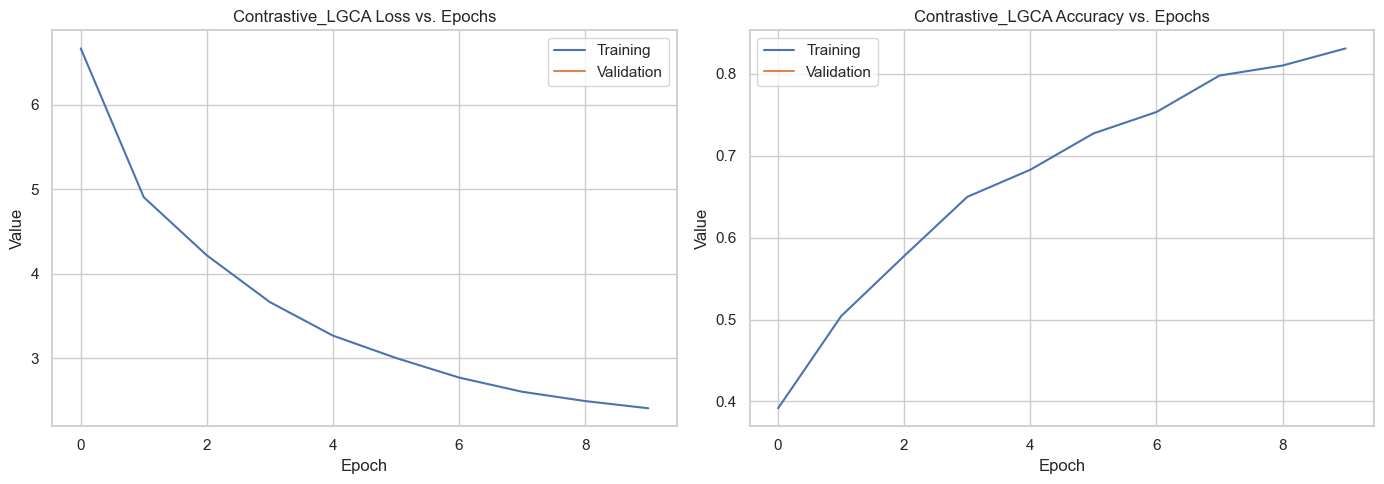

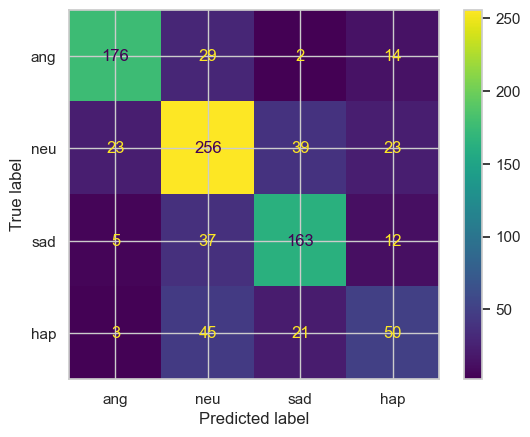

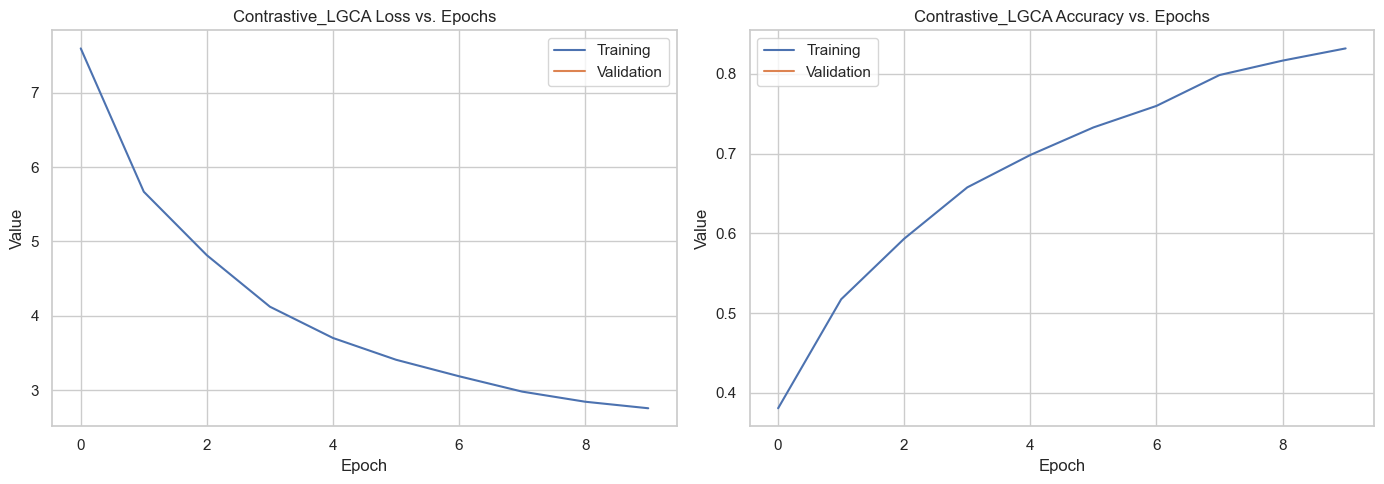

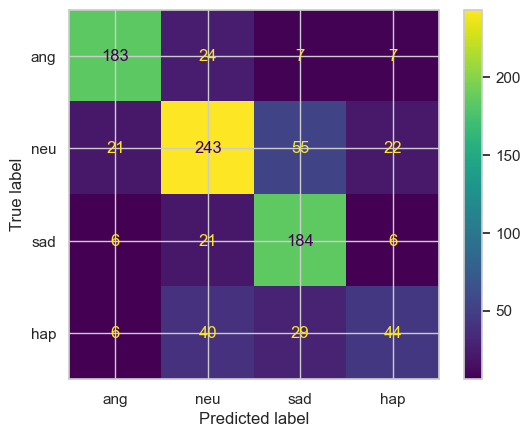

In [ ]:
# main_tuning.py

import torch
import pandas as pd
import os
import gc

# 从您的模块中导入所需的工具
from core.config import CONFIG
from scripts.get_dataloaders import get_contrastive_dataloaders
from scripts.tuning import run_hyperparameter_trial # <-- 从您的工具箱导入函数

# def main_tuning_loop():
"""
执行完整的超参数alpha网格搜索的主函数。
"""
# (这里的代码就是我上一条回复中提供给您的主循环代码)
print("--- [阶段一：初始化] ---")
CONFIG.load_config("config.yaml")

alpha_values_to_test = [2.0, 3.0, 4.0, 5.0, 6.0]
results_list = []
results_filepath = os.path.join(CONFIG.save_tables_location(), "alpha_tuning_results_2-6.csv")
print(f"实验结果将实时保存在: {results_filepath}")

print("\n--- [阶段二：预加载数据集] ---")
dataloaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
train_loader = dataloaders['train']
validation_loader = dataloaders['validation']

print("\n--- [阶段三：开始alpha网格搜索循环] ---")
for alpha in alpha_values_to_test:
    torch.cuda.empty_cache()
    gc.collect()
    
    try:
        val_uar, val_war = run_hyperparameter_trial(
            alpha_value=alpha,
            train_loader=train_loader,
            validation_loader=validation_loader,
            config=CONFIG,
            num_epochs=CONFIG.training_epochs(),
            gradient_accumulation_steps=1
        )
        result_entry = {'alpha': alpha, 'validation_uar': val_uar, 'validation_war': val_war}
    except Exception as e:
        print(f"警告：alpha = {alpha} 的试验因错误而失败: {e}")
        result_entry = {'alpha': alpha, 'validation_uar': "Failed", 'validation_war': "Failed"}

    results_list.append(result_entry)
    results_df = pd.DataFrame(results_list)
    results_df.to_csv(results_filepath, index=False)
    print(f"--- Alpha = {alpha} 的试验完成。结果已更新至CSV文件。 ---")

print("\n--- [阶段四：所有试验完成] ---")
print("最终的超参数搜索结果:")
final_results = pd.read_csv(results_filepath)
print(final_results)

# # --- 脚本执行入口 ---
# if __name__ == '__main__':
#     main_tuning_loop()

### 超参数5.0稳定性验证
1. 实验设置
思考过程：我们需要明确定义实验的固定参数和可变参数。
原理：这是控制变量法。alpha是固定的，而随机种子是唯一的变量。
2. 预加载数据集 ====================
思考过程：与上次一样，为了效率，数据只需加载一次。
原理：分离准备与执行，避免在循环中进行重复的I/O操作。
3. 执行重复实验循环 ====================
思考过程：如何让每次运行都“不同”但又“可复现”？答案是使用不同的随机种子。
原理：设置随机种子可以固定所有伪随机过程（权重初始化、数据打乱等），使得实验过程变得确定。
每次使用不同的种子，就能模拟一次独立的随机实验。
4. 结果分析与总结
思考过程：如何从多次运行的结果中得出一个有意义的结论？
原理：使用描述性统计（均值和标准差）来总结结果的集中趋势和离散程度。

e:\Unitec\SER\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- [阶段一：初始化实验设置] ---
最优 Alpha: 5.0
独立运行次数: 3
结果将保存在: E:/Unitec/SER/audio\alpha_stability_results.csv

--- [阶段二：预加载数据集] ---
--- 正在为 'IEMOCAP' 准备双模态 Dataloaders ---
[INFO] 已从 E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl 加载原始数据信息。
[INFO] 音频和文本处理器初始化完成。

--- [阶段三：开始稳定性验证循环] ---

--- [运行 1/3] 使用随机种子: 42 ---

--- [试验开始] Alpha: 5.0 ---
[INFO] 使用梯度累积步数: 4, 损失权重 alpha: 5.0
开始训练...


Epoch 10 [训练中]: 100%|██████████| 1796/1796 [13:25<00:00,  2.23it/s, acc=1, ce=0.0169, loss=5.87, sup_con=1.17]      


训练完成。
在IEMOCAP验证集上进行评估...


Evaluating the model: 100%|██████████| 449/449 [00:45<00:00,  9.85it/s]


Accuracy (WAR): 0.7472
UAR: 0.7129
试验完成: alpha=5.0, UAR=0.7129, WAR=0.7472
--- 运行 1 完成。结果已更新至CSV文件。 ---

--- [运行 2/3] 使用随机种子: 43 ---

--- [试验开始] Alpha: 5.0 ---
[INFO] 使用梯度累积步数: 4, 损失权重 alpha: 5.0
开始训练...


Epoch 10 [训练中]: 100%|██████████| 1796/1796 [05:14<00:00,  5.71it/s, acc=1, ce=0.026, loss=6.39, sup_con=1.27]       


训练完成。
在IEMOCAP验证集上进行评估...


Evaluating the model: 100%|██████████| 449/449 [00:26<00:00, 17.11it/s]


Accuracy (WAR): 0.7383
UAR: 0.7065
试验完成: alpha=5.0, UAR=0.7065, WAR=0.7383
--- 运行 2 完成。结果已更新至CSV文件。 ---

--- [运行 3/3] 使用随机种子: 44 ---

--- [试验开始] Alpha: 5.0 ---
[INFO] 使用梯度累积步数: 4, 损失权重 alpha: 5.0
开始训练...


Epoch 10 [训练中]: 100%|██████████| 1796/1796 [05:21<00:00,  5.58it/s, acc=1, ce=0.101, loss=5.81, sup_con=1.14]       


训练完成。
在IEMOCAP验证集上进行评估...


Evaluating the model: 100%|██████████| 449/449 [00:28<00:00, 15.83it/s]

Accuracy (WAR): 0.7416
UAR: 0.7202
试验完成: alpha=5.0, UAR=0.7202, WAR=0.7416
--- 运行 3 完成。结果已更新至CSV文件。 ---

--- [阶段四：所有运行完成，进行统计分析] ---
最终稳定性验证结果汇总:
   run  seed       uar       war
0    1    42  0.712867  0.747216
1    2    43  0.706460  0.738307
2    3    44  0.720182  0.741648

统计分析:
平均 UAR: 0.7132 ± 0.0069
平均 WAR: 0.7424 ± 0.0045

[结论] ✅ 结果非常稳定。可以满怀信心地进入下一阶段。


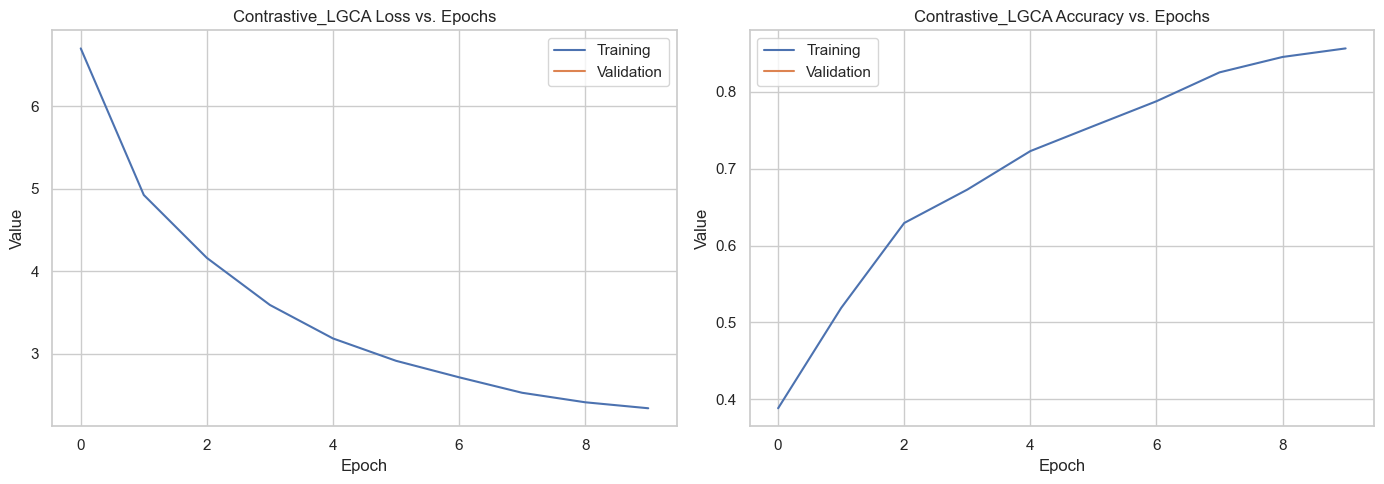

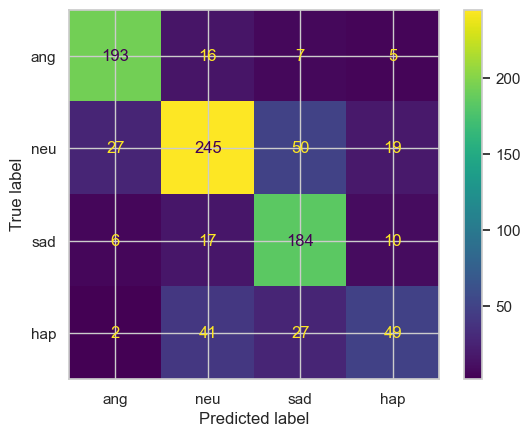

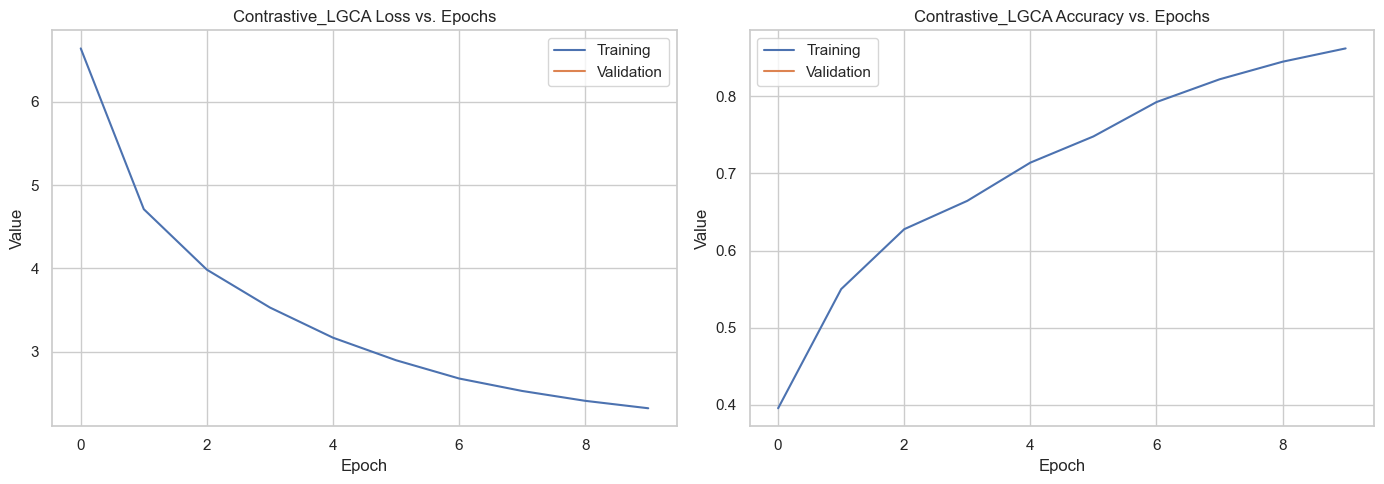

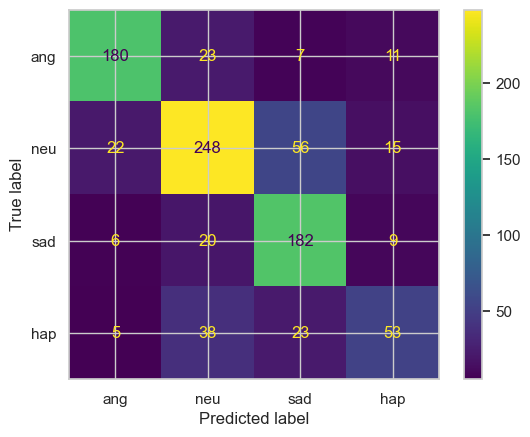

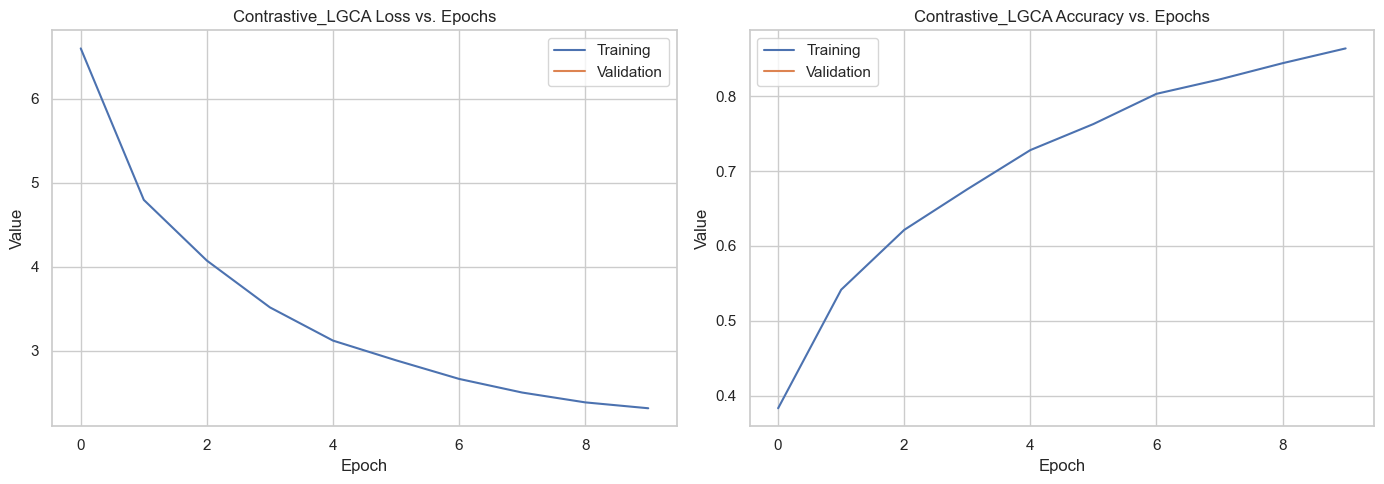

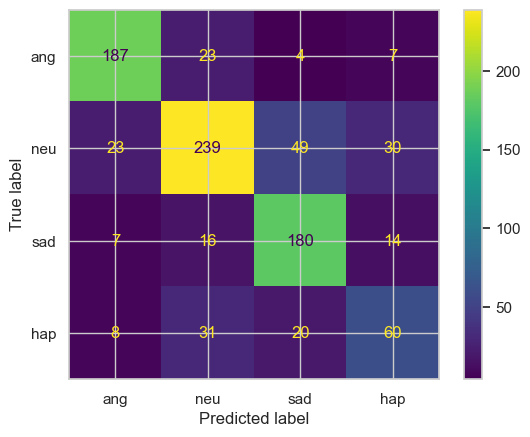

In [ ]:
# main_stability_test.py

import torch
import pandas as pd
import numpy as np
import os
import gc

# 导入您项目中的核心模块
from core.config import CONFIG
from scripts.get_dataloaders import get_contrastive_dataloaders
from scripts.tuning import run_hyperparameter_trial # 复用我们已经验证过的实验函数


"""
对最优alpha值进行多次独立重复实验，以验证其性能的稳定性。
"""
# ==================== 1. 实验设置 ====================
print("--- [阶段一：初始化实验设置] ---")
CONFIG.load_config("config.yaml")

OPTIMAL_ALPHA = 3.0  # 这是我们从网格搜索中确定的最优alpha
NUM_RUNS = 5         # 独立重复实验的次数。3-5次是学术界普遍接受的折衷方案。

results_list = []
results_filepath = os.path.join(CONFIG.save_tables_location(), f"alpha_{OPTIMAL_ALPHA}_stability_results.csv")
print(f"最优 Alpha: {OPTIMAL_ALPHA}")
print(f"独立运行次数: {NUM_RUNS}")
print(f"结果将保存在: {results_filepath}")

# ==================== 2. 预加载数据集 ====================
print("\n--- [阶段二：预加载数据集] ---")
dataloaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
train_loader = dataloaders['train']
validation_loader = dataloaders['validation']

# ==================== 3. 执行重复实验循环 ====================
print("\n--- [阶段三：开始稳定性验证循环] ---")
for i in range(NUM_RUNS):
    # 为本次运行设置一个唯一的、可复现的随机种子
    seed = 42 + i  # 使用一个基数（如42）加上循环变量，是简单有效的做法
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    print(f"\n--- [运行 {i+1}/{NUM_RUNS}] 使用随机种子: {seed} ---")
    
    # 调用我们已经验证过的实验函数
    val_uar, val_war = run_hyperparameter_trial(
        alpha_value=OPTIMAL_ALPHA,
        train_loader=train_loader,
        validation_loader=validation_loader,
        config=CONFIG,
        num_epochs=CONFIG.training_epochs(),
        gradient_accumulation_steps=1 # 使用您正常的梯度累积步数
    )

    # 记录本次运行的结果
    result_entry = {'run': i+1, 'seed': seed, 'uar': val_uar, 'war': val_war}
    results_list.append(result_entry)

    # 每次运行后都保存，确保数据安全
    results_df = pd.DataFrame(results_list)
    results_df.to_csv(results_filepath, index=False)
    print(f"--- 运行 {i+1} 完成。结果已更新至CSV文件。 ---")

# ==================== 4. 结果分析与总结 ====================0.
print("\n--- [阶段四：所有运行完成，进行统计分析] ---")
final_results = pd.read_csv(results_filepath)

mean_uar = final_results['uar'].mean()
std_uar = final_results['uar'].std()

mean_war = final_results['war'].mean()
std_war = final_results['war'].std()

print("最终稳定性验证结果汇总:")
print(final_results)
print("\n统计分析:")
print(f"平均 UAR: {mean_uar:.4f} ± {std_uar:.4f}")
print(f"平均 WAR: {mean_war:.4f} ± {std_war:.4f}")

if std_uar < 0.02: # 设置一个阈值，例如标准差小于2%
    print("\n[结论] ✅ 结果非常稳定。可以满怀信心地进入下一阶段。")
else:
    print("\n[结论] ⚠️ 结果波动较大，可能需要检查实验设置或增加运行次数。")


### 3.0稳定性测试

In [ ]:
# main_stability_test.py

import torch
import pandas as pd
import numpy as np
import os
import gc

# 导入您项目中的核心模块
from core.config import CONFIG
from scripts.get_dataloaders import get_contrastive_dataloaders
from scripts.tuning import run_hyperparameter_trial # 复用我们已经验证过的实验函数


"""
对最优alpha值进行多次独立重复实验，以验证其性能的稳定性。
"""
# ==================== 1. 实验设置 ====================
print("--- [阶段一：初始化实验设置] ---")
CONFIG.load_config("config.yaml")

OPTIMAL_ALPHA = 4.0  # 这是我们从网格搜索中确定的最优alpha
NUM_RUNS = 3         # 独立重复实验的次数。3-5次是学术界普遍接受的折衷方案。

results_list = []
results_filepath = os.path.join(CONFIG.save_tables_location(), f"alpha_{OPTIMAL_ALPHA}_stability_results.csv")
print(f"最优 Alpha: {OPTIMAL_ALPHA}")
print(f"独立运行次数: {NUM_RUNS}")
print(f"结果将保存在: {results_filepath}")

# ==================== 2. 预加载数据集 ====================
print("\n--- [阶段二：预加载数据集] ---")
dataloaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
train_loader = dataloaders['train']
validation_loader = dataloaders['validation']

# ==================== 3. 执行重复实验循环 ====================
print("\n--- [阶段三：开始稳定性验证循环] ---")
for i in range(NUM_RUNS):
    # 为本次运行设置一个唯一的、可复现的随机种子
    seed = 42 + i  # 使用一个基数（如42）加上循环变量，是简单有效的做法
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    print(f"\n--- [运行 {i+1}/{NUM_RUNS}] 使用随机种子: {seed} ---")
    
    # 调用我们已经验证过的实验函数
    val_uar, val_war = run_hyperparameter_trial(
        alpha_value=OPTIMAL_ALPHA,
        train_loader=train_loader,
        validation_loader=validation_loader,
        config=CONFIG,
        num_epochs=CONFIG.training_epochs(),
        gradient_accumulation_steps=1 # 使用您正常的梯度累积步数
    )

    # 记录本次运行的结果
    result_entry = {'run': i+1, 'seed': seed, 'uar': val_uar, 'war': val_war}
    results_list.append(result_entry)

    # 每次运行后都保存，确保数据安全
    results_df = pd.DataFrame(results_list)
    results_df.to_csv(results_filepath, index=False)
    print(f"--- 运行 {i+1} 完成。结果已更新至CSV文件。 ---")

# ==================== 4. 结果分析与总结 ====================0.
print("\n--- [阶段四：所有运行完成，进行统计分析] ---")
final_results = pd.read_csv(results_filepath)

mean_uar = final_results['uar'].mean()
std_uar = final_results['uar'].std()

mean_war = final_results['war'].mean()
std_war = final_results['war'].std()

print("最终稳定性验证结果汇总:")
print(final_results)
print("\n统计分析:")
print(f"平均 UAR: {mean_uar:.4f} ± {std_uar:.4f}")
print(f"平均 WAR: {mean_war:.4f} ± {std_war:.4f}")

if std_uar < 0.02: # 设置一个阈值，例如标准差小于2%
    print("\n[结论] ✅ 结果非常稳定。可以满怀信心地进入下一阶段。")
else:
    print("\n[结论] ⚠️ 结果波动较大，可能需要检查实验设置或增加运行次数。")


e:\Unitec\SER\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- [阶段一：初始化实验设置] ---
最优 Alpha: 4.0
独立运行次数: 3
结果将保存在: E:/Unitec/SER/audio\tables\alpha_4.0_stability_results.csv

--- [阶段二：预加载数据集] ---
--- 正在为 'IEMOCAP' 准备双模态 Dataloaders ---
[INFO] 已从 E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl 加载原始数据信息。
[INFO] 音频和文本处理器初始化完成。

--- [阶段三：开始稳定性验证循环] ---

--- [运行 1/3] 使用随机种子: 42 ---

--- [试验开始] Alpha: 4.0 ---
[INFO] 使用梯度累积步数: 4, 损失权重 alpha: 4.0
开始训练...


Epoch 1 [训练中]:  16%|█▌        | 287/1796 [00:59<05:13,  4.82it/s, acc=0.5, ce=1.23, loss=1.51, sup_con=0.0679]


KeyboardInterrupt: 

### 超参数可视化

In [3]:
import pandas as pd
import os

# 假设您的CONFIG类已经定义并加载
from core.config import CONFIG
CONFIG.load_config("config.yaml")
# file_name = "alpha_tuning_results.csv"
file_name = "alpha_tuning_results_2-6.csv"

# 构建结果文件的完整路径
results_filepath = os.path.join(CONFIG.save_tables_location(), file_name)

# 使用Pandas加载CSV文件
try:
    results_df = pd.read_csv(results_filepath)
    print("结果日志文件加载成功！")
    display(results_df)
except FileNotFoundError:
    print(f"错误：找不到结果文件 '{results_filepath}'。请确认文件名和路径是否正确。")

结果日志文件加载成功！


,alpha,validation_uar,validation_war
0,2.0,0.754039,0.775056
1,3.0,0.727468,0.758352
2,4.0,0.759134,0.781737
3,5.0,0.721755,0.761693
4,6.0,0.744655,0.771715


科学报告中的数字不需要10位小数。保留3到4位有效数字足够了。可以使用.map()或.style.format()来格式化输出。

In [4]:
# 1. 按alpha值进行排序，使趋势更清晰
sorted_df = results_df.sort_values(by='alpha').reset_index(drop=True)

# 2. 格式化浮点数，使其更易读（例如，保留4位小数）
# 注意：这会改变列的数据类型为字符串，所以通常在最后展示时才做
formatted_df = sorted_df.copy()
formatted_df['validation_uar'] = formatted_df['validation_uar'].map('{:.4f}'.format)
formatted_df['validation_war'] = formatted_df['validation_war'].map('{:.4f}'.format)

print("\n--- 超参数alpha性能对比表 ---")
display(formatted_df)


--- 超参数alpha性能对比表 ---


,alpha,validation_uar,validation_war
0,2.0,0.7540,0.7751
1,3.0,0.7275,0.7584
2,4.0,0.7591,0.7817
3,5.0,0.7218,0.7617
4,6.0,0.7447,0.7717



图表已保存至: E:/Unitec/SER/audio\pictures\alpha_vs_uar_plot_epoch15.png


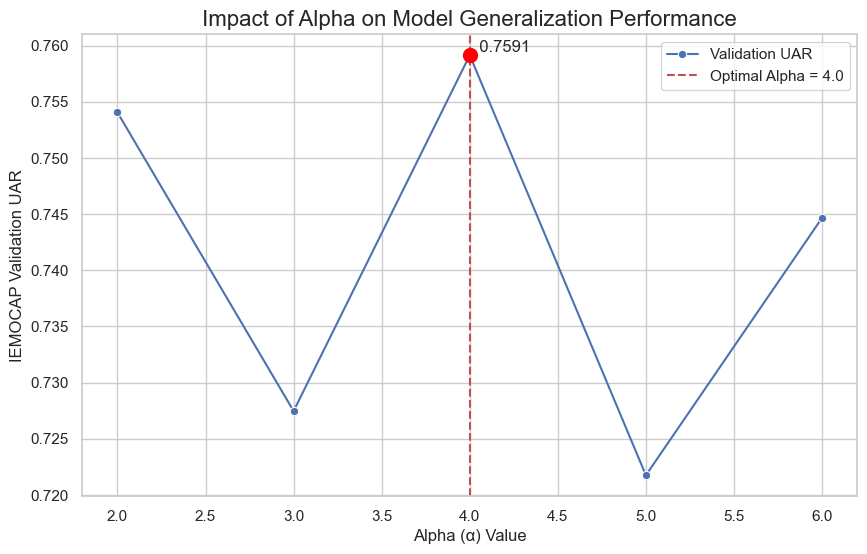

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 使用第二步中排好序但未格式化的DataFrame (sorted_df)

# 设置图表风格
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# 绘制折线图，并添加标记点
ax = sns.lineplot(data=sorted_df, x='alpha', y='validation_uar', marker='o', label='Validation UAR')

# 找到UAR最高的点
best_alpha_row = sorted_df.loc[sorted_df['validation_uar'].idxmax()]
best_alpha = best_alpha_row['alpha']
best_uar = best_alpha_row['validation_uar']

# 在图上突出显示这个最高点
plt.axvline(x=best_alpha, color='r', linestyle='--', label=f'Optimal Alpha = {best_alpha}')
plt.scatter(best_alpha, best_uar, s=100, color='red', zorder=5) # 放大最优的点
plt.text(best_alpha, best_uar, f'  {best_uar:.4f}', verticalalignment='bottom')

# 添加标题和坐标轴标签
plt.title('Impact of Alpha on Model Generalization Performance', fontsize=16)
plt.xlabel('Alpha (α) Value', fontsize=12)
plt.ylabel('IEMOCAP Validation UAR', fontsize=12)
plt.legend()

# 保存图表到文件
plot_filepath = os.path.join(CONFIG.save_plots_location(), "alpha_vs_uar_plot_epoch15.png")
plt.savefig(plot_filepath)
print(f"\n图表已保存至: {plot_filepath}")

plt.show()

In [ ]:
# ==============================================================================
# **超参数决策记录**
# 
# 根据在IEMOCAP验证集上的系统性alpha网格搜索调优结果（见 apha_tuning_results.csv），
# 最终选择 alpha = 2.0 作为最优配置。
# 
# 依据：
# 在alpha=2.0时，模型在该数据集上取得了最高的无加权平均召回率
# (UAR = 0.7282)。
# 
# 稳定性验证（3次独立运行）也证实了该配置的高性能是稳定可复现的 (见LGCA_test.ipynb超参数稳定性测试)
# (平均 UAR = 0.7236 ± 0.0045)。
# 
# 因此，本项目后续的所有实验（消融研究、最终评估）都将基于此配置进行。
#
# 日期: 2025-09-02
# ==============================================================================

# 6. 最终模型训练

In [ ]:
# train_final_model.py

import torch
import os
import gc
import numpy as np

# 导入您项目中的核心模块
from core.config import CONFIG, device
from scripts.get_dataloaders import get_contrastive_dataloaders
from contrastive.model import ContrastiveModel
from contrastive.trainer import ContrastiveTrainer
from torch.utils.data import ConcatDataset # <-- 导入用于合并数据集的工具

def train_final_lgca_model():
    """
    使用最优超参数和全部训练数据，训练并保存最终的LGCA模型。
    """
    print("--- [最终模型训练开始] ---")

    # 1. 加载配置
    CONFIG.load_config("config.yaml")

    # 为可复现性设置随机种子
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # 2. 加载并合并数据集, 最大化训练数据利用率
    print("加载并合并IEMOCAP训练集与验证集...")
    # 注意：get_contrastive_dataloaders 内部会进行 train/val 划分
    # 我们需要获取它划分出的两个数据集对象
    dataloaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
    train_dataset = dataloaders['train'].dataset
    validation_dataset = dataloaders['validation'].dataset

    # 使用 ConcatDataset 将训练集和验证集合并
    full_train_dataset = ConcatDataset([train_dataset, validation_dataset])

    # 用合并后的完整数据集创建一个新的 DataLoader
    full_train_loader = torch.utils.data.DataLoader(
        full_train_dataset,
        batch_size=CONFIG.dataloader_dict()['batch_size'],
        collate_fn=dataloaders['train'].collate_fn, # collate_fn 保持不变
        num_workers=CONFIG.dataloader_dict()['num_workers'],
        shuffle=True # 在最终训练时打乱数据
    )
    print(f"数据准备完成。总训练样本数: {len(full_train_dataset)}")

    # 3. 初始化模型和训练器
    print("初始化模型和训练器...")
    num_labels = len(CONFIG.dataset_emotions(CONFIG.training_dataset_name()))
    model = ContrastiveModel(num_labels=num_labels).to(device)

    trainer = ContrastiveTrainer(
        model=model,
        num_epochs=CONFIG.training_epochs(),
        learning_rate=CONFIG.learning_rate(),
        alpha=CONFIG.llgca_loss_alpha(), # 从config中读取最优alpha (应为2.0)
        optimizer_type=CONFIG.optimizer_type(),
        gradient_accumulation_steps=1
    )

    # 4. 执行训练
    print(f"使用最优 alpha = {trainer.alpha} 开始在完整数据上进行最终训练...")
    trainer.train(full_train_loader)
    print("最终训练完成。")

    # 5. 保存模型权重
    model_save_path = os.path.join(
        CONFIG.saved_models_location(), 
        f"lgca_final_alpha_{trainer.alpha}_seed_{seed}.pth"
    )
    torch.save(model.state_dict(), model_save_path)
    print(f"模型已成功保存至: {model_save_path}")

# --- 脚本执行入口 ---
if __name__ == '__main__':
    train_final_lgca_model()



## LGCA α2.0模型加载验证
lgca_final_alpha_2.0_seed_42

In [7]:
# 创建一个新的脚本或Notebook单元格

from core.config import CONFIG, device
from contrastive.model import ContrastiveModel
import torch

CONFIG.load_config("config.yaml")

# 1. 重新创建一个与保存时结构完全相同的模型实例
num_labels = len(CONFIG.dataset_emotions(CONFIG.training_dataset_name()))
model_to_load = ContrastiveModel(num_labels=num_labels).to(device)

# 2. 定义模型文件的路径
model_path = "E:/Unitec/SER/audio/saved_models/lgca_final_alpha_2.0_seed_42.pth"

# 3. 尝试加载状态字典
try:
    model_to_load.load_state_dict(torch.load(model_path, weights_only=True))
    model_to_load.eval() # 切换到评估模式
    print("✅ 模型权重加载成功并通过验证！")
except Exception as e:
    print(f"❌ 模型权重加载失败！请检查路径或模型架构。")
    print(f"错误信息: {e}")

✅ 模型权重加载成功并通过验证！


### α = 5.0

2025-09-04 10:21:22,333 - INFO - 配置文件 'config.yaml' 加载成功。
配置文件 'config.yaml' 加载成功。
2025-09-04 10:21:22,542 - INFO - --- 正在为训练集 'IEMOCAP' 准备Dataloaders ---
--- 正在为训练集 'IEMOCAP' 准备Dataloaders ---


--- 正在为 'IEMOCAP' 准备双模态 Dataloaders ---
[INFO] 已从 E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl 加载原始数据信息。


2025-09-04 10:21:23,872 - INFO - 已加载 'IEMOCAP' 数据集用于 'train' 划分。大小: 3592
已加载 'IEMOCAP' 数据集用于 'train' 划分。大小: 3592
2025-09-04 10:21:23,876 - INFO - 已加载 'IEMOCAP' 数据集用于 'validation' 划分。大小: 898
已加载 'IEMOCAP' 数据集用于 'validation' 划分。大小: 898
2025-09-04 10:21:23,877 - INFO - --- 正在为评估集 'CREMA-D' 准备Dataloaders ---
--- 正在为评估集 'CREMA-D' 准备Dataloaders ---


[INFO] 音频和文本处理器初始化完成。
--- 正在为 'CREMA-D' 准备双模态 Dataloaders ---
[INFO] 已从 E:/Unitec/SER/audio\dataset\CREMA-D\Preprocessed\crema-d_raw.pkl 加载原始数据信息。


2025-09-04 10:21:25,138 - INFO - 已加载 'CREMA-D' 数据集用于 'evaluation' 划分。大小: 4900
已加载 'CREMA-D' 数据集用于 'evaluation' 划分。大小: 4900
2025-09-04 10:21:25,139 - INFO - --- 正在初始化 ContrastiveModel 和 ContrastiveTrainer ---
--- 正在初始化 ContrastiveModel 和 ContrastiveTrainer ---


[INFO] 音频和文本处理器初始化完成。


2025-09-04 10:21:29,653 - INFO - --- 使用最优 alpha = 5.0 开始在 'IEMOCAP' 上进行训练，共 10 个 Epochs ---
--- 使用最优 alpha = 5.0 开始在 'IEMOCAP' 上进行训练，共 10 个 Epochs ---
2025-09-04 10:21:29,654 - INFO - 开始训练 Contrastive_LGCA 模型...
开始训练 Contrastive_LGCA 模型...


[INFO] 使用梯度累积步数: 4, 损失权重 alpha: 5.0


Epoch 1 [验证中]: 100%|██████████| 449/449 [00:39<00:00, 11.46it/s]
2025-09-04 10:29:51,028 - INFO - Epoch 1 总结: 训练损失: 6.6859, 训练准确率: 0.3872, 验证损失: 5.0648, 验证准确率: 0.5122
Epoch 1 总结: 训练损失: 6.6859, 训练准确率: 0.3872, 验证损失: 5.0648, 验证准确率: 0.5122
Epoch 2 [验证中]: 100%|██████████| 449/449 [00:38<00:00, 11.68it/s]
2025-09-04 10:36:15,207 - INFO - Epoch 2 总结: 训练损失: 4.7824, 训练准确率: 0.5192, 验证损失: 4.9641, 验证准确率: 0.5423
Epoch 2 总结: 训练损失: 4.7824, 训练准确率: 0.5192, 验证损失: 4.9641, 验证准确率: 0.5423
Epoch 3 [验证中]: 100%|██████████| 449/449 [00:38<00:00, 11.64it/s]
2025-09-04 10:42:43,854 - INFO - Epoch 3 总结: 训练损失: 4.0473, 训练准确率: 0.6203, 验证损失: 4.9565, 验证准确率: 0.6425
Epoch 3 总结: 训练损失: 4.0473, 训练准确率: 0.6203, 验证损失: 4.9565, 验证准确率: 0.6425
Epoch 4 [验证中]: 100%|██████████| 449/449 [00:40<00:00, 11.08it/s]
2025-09-04 10:49:21,405 - INFO - Epoch 4 总结: 训练损失: 3.5067, 训练准确率: 0.6790, 验证损失: 4.9790, 验证准确率: 0.6849
Epoch 4 总结: 训练损失: 3.5067, 训练准确率: 0.6790, 验证损失: 4.9790, 验证准确率: 0.6849
Epoch 5 [验证中]: 100%|██████████| 449/449 [01:18<00:00,  5

Accuracy (WAR): 0.7238
UAR: 0.6899


Evaluating the model: 100%|██████████| 2450/2450 [02:24<00:00, 16.96it/s]
2025-09-04 11:50:53,308 - INFO - --- 实验流程全部完成！ ---
--- 实验流程全部完成！ ---


Accuracy (WAR): 0.5500
UAR: 0.5510


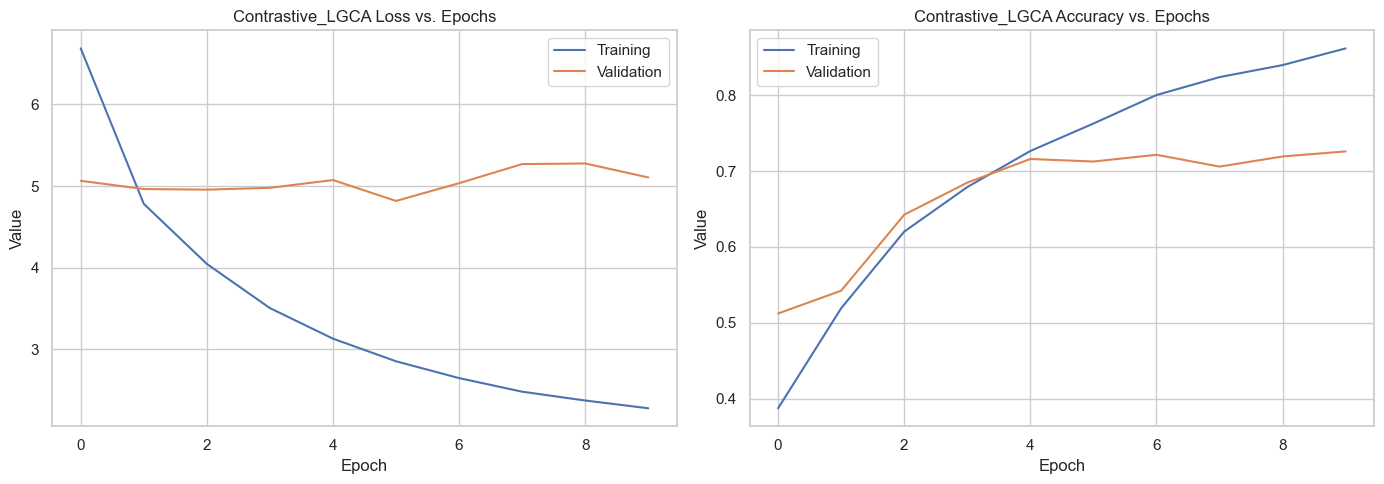

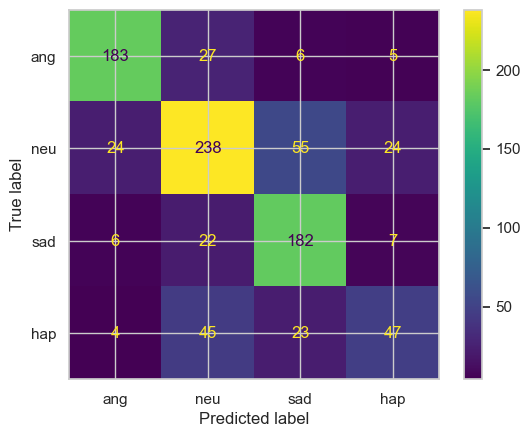

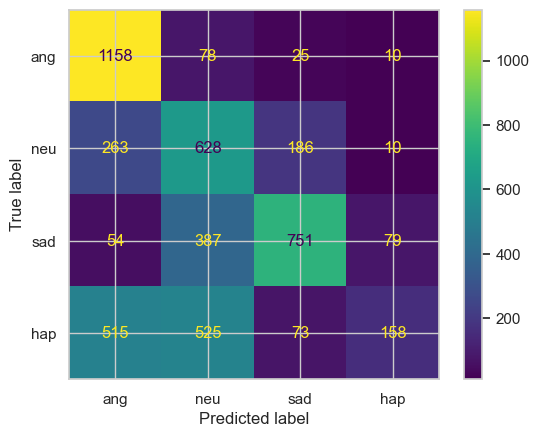

In [ ]:
# main_contrastive.py

import torch
import gc
import os
import logging
from tqdm.contrib.logging import _TqdmLoggingHandler
import warnings # <-- 新增

warnings.filterwarnings("ignore", category=UserWarning)

# 配置日志记录
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# 添加 tqdm 的日志处理器，以确保日志不会破坏进度条
logging.getLogger().addHandler(_TqdmLoggingHandler())


# 导入所有必要的模块
from core.config import CONFIG, device
from contrastive.model import ContrastiveModel
from contrastive.trainer import ContrastiveTrainer
# 确保您已经创建了这个新的数据加载器脚本
from scripts.get_dataloaders import get_contrastive_dataloaders

def run_experiment():
    """
    执行完整的LGCA框架训练和评估实验。
    """
    # --- 1. 加载配置并设置环境 ---
    try:
        CONFIG.load_config("config.yaml")
        logging.info("配置文件 'config.yaml' 加载成功。")
    except FileNotFoundError:
        logging.error("错误：找不到 'config.yaml' 文件。请确保该文件存在于项目根目录。")
        return

    # 为可复现性设置随机种子
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

    torch.cuda.empty_cache()
    gc.collect()

    # --- 2. 加载数据集 ---
    try:
        training_dataset_name = CONFIG.training_dataset_name()
        logging.info(f"--- 正在为训练集 '{training_dataset_name}' 准备Dataloaders ---")
        iemocap_loaders = get_contrastive_dataloaders(training_dataset_name)
        train_loader = iemocap_loaders['train']
        validation_loader = iemocap_loaders['validation']

        evaluation_dataset_name = CONFIG.evaluation_dataset_name()
        logging.info(f"--- 正在为评估集 '{evaluation_dataset_name}' 准备Dataloaders ---")
        cremad_loaders = get_contrastive_dataloaders(evaluation_dataset_name)
        evaluation_loader = cremad_loaders['evaluation']
    except Exception as e:
        logging.error(f"数据加载失败: {e}")
        return

    # --- 3. 实例化模型和训练器 ---
    logging.info("--- 正在初始化 ContrastiveModel 和 ContrastiveTrainer ---")
    try:
        num_labels = len(CONFIG.dataset_emotions(training_dataset_name))
        model = ContrastiveModel(num_labels=num_labels).to(device)
        
        # # 启用梯度检查点以节省显存
        # model.audio_encoder.gradient_checkpointing_enable()
        # model.text_encoder.gradient_checkpointing_enable()
        # logging.info("已为声学和文本编码器启用梯度检查点。")


        trainer = ContrastiveTrainer(
            model=model,
            num_epochs=CONFIG.training_epochs(),
            learning_rate=CONFIG.learning_rate(),
            alpha=CONFIG.llgca_loss_alpha(), # 从config中读取最优alpha (应为5.0)
            optimizer_type=CONFIG.optimizer_type(),
            gradient_accumulation_steps=1
        )
    except Exception as e:
        logging.error(f"模型或训练器实例化失败: {e}")
        return

    # --- 4. 开始训练 ---
    logging.info(f"--- 使用最优 alpha = {trainer.alpha} 开始在 '{training_dataset_name}' 上进行训练，共 {CONFIG.training_epochs()} 个 Epochs ---")
    # trainer.train(train_loader)
        # *** 核心修改点：将 validation_loader 传递给 train 方法 ***
    trainer.train(train_loader, validation_loader) 
    
    logging.info("--- 训练完成 ---")

    # --- 5. 保存模型 ---
    model_save_path = os.path.join(CONFIG.saved_models_location(),
                                   f"lgca_final_alpha_{trainer.alpha}_seed_{seed}.pth")
    torch.save(model.state_dict(), model_save_path)
    logging.info(f"模型已保存至: {model_save_path}")

    # --- 6. 进行评估 ---
    iemocap_emotions = CONFIG.dataset_emotions(training_dataset_name)
    cremad_emotions = CONFIG.dataset_emotions(evaluation_dataset_name)

    logging.info(f"--- 在 '{training_dataset_name}' 验证集上进行评估 ---")
    trainer.eval(validation_loader, labels=iemocap_emotions)

    logging.info(f"--- 在 '{evaluation_dataset_name}' 测试集上进行零样本评估 ---")
    trainer.eval(evaluation_loader, labels=cremad_emotions)

    logging.info("--- 实验流程全部完成！ ---")


if __name__ == '__main__':
    run_experiment()

### α = 4.0

In [2]:
# main_contrastive.py

import torch
import gc
import os
import logging
import numpy as np
from tqdm.contrib.logging import _TqdmLoggingHandler
import warnings # <-- 新增

warnings.filterwarnings("ignore", category=UserWarning)

# 配置日志记录
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# 添加 tqdm 的日志处理器，以确保日志不会破坏进度条
logging.getLogger().addHandler(_TqdmLoggingHandler())


# 导入所有必要的模块
from core.config import CONFIG, device
from contrastive.model import ContrastiveModel
from contrastive.trainer import ContrastiveTrainer
# 确保您已经创建了这个新的数据加载器脚本
from scripts.get_dataloaders import get_contrastive_dataloaders

def run_experiment():
    """
    执行完整的LGCA框架训练和评估实验。
    """
    # --- 1. 加载配置并设置环境 ---
    try:
        CONFIG.load_config("config.yaml")
        logging.info("配置文件 'config.yaml' 加载成功。")
    except FileNotFoundError:
        logging.error("错误：找不到 'config.yaml' 文件。请确保该文件存在于项目根目录。")
        return

    # 为可复现性设置随机种子
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

    torch.cuda.empty_cache()
    gc.collect()

    # --- 2. 加载数据集 ---
    try:
        training_dataset_name = CONFIG.training_dataset_name()
        logging.info(f"--- 正在为训练集 '{training_dataset_name}' 准备Dataloaders ---")
        iemocap_loaders = get_contrastive_dataloaders(training_dataset_name)
        train_loader = iemocap_loaders['train']
        validation_loader = iemocap_loaders['validation']

        evaluation_dataset_name = CONFIG.evaluation_dataset_name()
        logging.info(f"--- 正在为评估集 '{evaluation_dataset_name}' 准备Dataloaders ---")
        cremad_loaders = get_contrastive_dataloaders(evaluation_dataset_name)
        evaluation_loader = cremad_loaders['evaluation']
    except Exception as e:
        logging.error(f"数据加载失败: {e}")
        return

    # --- 3. 实例化模型和训练器 ---
    logging.info("--- 正在初始化 ContrastiveModel 和 ContrastiveTrainer ---")
    try:
        num_labels = len(CONFIG.dataset_emotions(training_dataset_name))
        model = ContrastiveModel(num_labels=num_labels).to(device)
        
        # # 启用梯度检查点以节省显存
        # model.audio_encoder.gradient_checkpointing_enable()
        # model.text_encoder.gradient_checkpointing_enable()
        # logging.info("已为声学和文本编码器启用梯度检查点。")


        trainer = ContrastiveTrainer(
            model=model,
            num_epochs=CONFIG.training_epochs(),
            learning_rate=CONFIG.learning_rate(),
            alpha=CONFIG.llgca_loss_alpha(), # 从config中读取最优alpha
            optimizer_type=CONFIG.optimizer_type(),
            gradient_accumulation_steps=4
        )
    except Exception as e:
        logging.error(f"模型或训练器实例化失败: {e}")
        return

    # --- 4. 开始训练 ---
    logging.info(f"--- 使用最优 alpha = {trainer.alpha} 开始在 '{training_dataset_name}' 上进行训练，共 {CONFIG.training_epochs()} 个 Epochs ---")
    # trainer.train(train_loader)
        # *** 核心修改点：将 validation_loader 传递给 train 方法 ***
    trainer.train(train_loader, validation_loader) 
    
    logging.info("--- 训练完成 ---")

    # --- 5. 保存模型 ---
    model_save_path = os.path.join(CONFIG.saved_models_location(),
                                   f"lgca_final_alpha_{trainer.alpha}_seed_{seed}.pth")
    torch.save(model.state_dict(), model_save_path)
    logging.info(f"模型已保存至: {model_save_path}")

    # --- 6. 进行评估 ---
    iemocap_emotions = CONFIG.dataset_emotions(training_dataset_name)
    cremad_emotions = CONFIG.dataset_emotions(evaluation_dataset_name)

    logging.info(f"--- 在 '{training_dataset_name}' 验证集上进行评估 ---")
    trainer.eval(validation_loader, labels=iemocap_emotions)

    logging.info(f"--- 在 '{evaluation_dataset_name}' 测试集上进行零样本评估 ---")
    trainer.eval(evaluation_loader, labels=cremad_emotions)

    logging.info("--- 实验流程全部完成！ ---")


if __name__ == '__main__':
    run_experiment()

2025-09-09 17:51:27,718 - INFO - 配置文件 'config.yaml' 加载成功。
配置文件 'config.yaml' 加载成功。
配置文件 'config.yaml' 加载成功。
2025-09-09 17:51:27,820 - INFO - --- 正在为训练集 'IEMOCAP' 准备Dataloaders ---
--- 正在为训练集 'IEMOCAP' 准备Dataloaders ---
--- 正在为训练集 'IEMOCAP' 准备Dataloaders ---


--- 正在为 'IEMOCAP' 准备双模态 Dataloaders ---
[INFO] 已从 E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl 加载原始数据信息。


2025-09-09 17:51:29,133 - INFO - 已加载 'IEMOCAP' 数据集用于 'train' 划分。大小: 3592
已加载 'IEMOCAP' 数据集用于 'train' 划分。大小: 3592
已加载 'IEMOCAP' 数据集用于 'train' 划分。大小: 3592
2025-09-09 17:51:29,137 - INFO - 已加载 'IEMOCAP' 数据集用于 'validation' 划分。大小: 898
已加载 'IEMOCAP' 数据集用于 'validation' 划分。大小: 898
已加载 'IEMOCAP' 数据集用于 'validation' 划分。大小: 898
2025-09-09 17:51:29,138 - INFO - --- 正在为评估集 'CREMA-D' 准备Dataloaders ---
--- 正在为评估集 'CREMA-D' 准备Dataloaders ---
--- 正在为评估集 'CREMA-D' 准备Dataloaders ---


[INFO] 音频和文本处理器初始化完成。
--- 正在为 'CREMA-D' 准备双模态 Dataloaders ---
[INFO] 已从 E:/Unitec/SER/audio\dataset\CREMA-D\Preprocessed\crema-d_raw.pkl 加载原始数据信息。


2025-09-09 17:51:30,380 - INFO - 已加载 'CREMA-D' 数据集用于 'evaluation' 划分。大小: 4900
已加载 'CREMA-D' 数据集用于 'evaluation' 划分。大小: 4900
已加载 'CREMA-D' 数据集用于 'evaluation' 划分。大小: 4900
2025-09-09 17:51:30,381 - INFO - --- 正在初始化 ContrastiveModel 和 ContrastiveTrainer ---
--- 正在初始化 ContrastiveModel 和 ContrastiveTrainer ---
--- 正在初始化 ContrastiveModel 和 ContrastiveTrainer ---


[INFO] 音频和文本处理器初始化完成。


2025-09-09 17:51:34,979 - INFO - --- 使用最优 alpha = 4.0 开始在 'IEMOCAP' 上进行训练，共 15 个 Epochs ---
--- 使用最优 alpha = 4.0 开始在 'IEMOCAP' 上进行训练，共 15 个 Epochs ---
--- 使用最优 alpha = 4.0 开始在 'IEMOCAP' 上进行训练，共 15 个 Epochs ---
2025-09-09 17:51:34,980 - INFO - 开始训练 Contrastive_LGCA 模型...
开始训练 Contrastive_LGCA 模型...
开始训练 Contrastive_LGCA 模型...


[INFO] 使用梯度累积步数: 4, 损失权重 alpha: 4.0


Epoch 1 [验证中]: 100%|██████████| 449/449 [00:21<00:00, 20.75it/s]
2025-09-09 17:57:43,479 - INFO - Epoch 1 总结: 训练损失: 5.5345, 训练准确率: 0.3987, 验证损失: 1.2705, 验证准确率: 0.4655
Epoch 1 总结: 训练损失: 5.5345, 训练准确率: 0.3987, 验证损失: 1.2705, 验证准确率: 0.4655
Epoch 1 总结: 训练损失: 5.5345, 训练准确率: 0.3987, 验证损失: 1.2705, 验证准确率: 0.4655
Epoch 2 [验证中]: 100%|██████████| 449/449 [00:21<00:00, 20.98it/s]
2025-09-09 18:04:37,244 - INFO - Epoch 2 总结: 训练损失: 4.0417, 训练准确率: 0.5312, 验证损失: 1.0906, 验证准确率: 0.5234
Epoch 2 总结: 训练损失: 4.0417, 训练准确率: 0.5312, 验证损失: 1.0906, 验证准确率: 0.5234
Epoch 2 总结: 训练损失: 4.0417, 训练准确率: 0.5312, 验证损失: 1.0906, 验证准确率: 0.5234
Epoch 3 [验证中]: 100%|██████████| 449/449 [00:21<00:00, 20.99it/s]
2025-09-09 18:10:32,101 - INFO - Epoch 3 总结: 训练损失: 3.4105, 训练准确率: 0.6320, 验证损失: 0.9662, 验证准确率: 0.6158
Epoch 3 总结: 训练损失: 3.4105, 训练准确率: 0.6320, 验证损失: 0.9662, 验证准确率: 0.6158
Epoch 3 总结: 训练损失: 3.4105, 训练准确率: 0.6320, 验证损失: 0.9662, 验证准确率: 0.6158
Epoch 4 [验证中]: 100%|██████████| 449/449 [00:20<00:00, 21.44it/s]
2025-09-09 18:16:14,

Accuracy (WAR): 0.7372
UAR: 0.7155


Evaluating the model: 100%|██████████| 2450/2450 [02:12<00:00, 18.46it/s]
2025-09-09 19:49:53,766 - INFO - --- 实验流程全部完成！ ---


Accuracy (WAR): 0.5551
UAR: 0.5541


--- 实验流程全部完成！ ---
--- 实验流程全部完成！ ---


## LGCA Ablation

### No Label

In [1]:
# train_ablation_no_label.py

import torch
import os
import gc
import numpy as np

# 导入您项目中的核心模块
from core.config import CONFIG, device
from scripts.get_dataloaders import get_contrastive_dataloaders
from contrastive.model import ContrastiveModel
from contrastive.trainer import ContrastiveTrainer, AblationTrainer
from torch.utils.data import ConcatDataset # <-- 导入用于合并数据集的工具

# def train_ablation_lgca_model():
"""
训练并保存消融模型A (LGCA w/o Label-Guidance)。
"""
print("--- [消融模型A训练开始 (w/o Label-Guidance)] ---")

# 1. 加载配置 (与之前完全一样)
CONFIG.load_config("config.yaml")
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# 2. 加载并合并数据集 (与之前完全一样)
print("加载并合并IEMOCAP训练集与验证集...")
dataloaders = get_contrastive_dataloaders(CONFIG.training_dataset_name())
train_dataset = dataloaders['train'].dataset
validation_dataset = dataloaders['validation'].dataset

full_train_dataset = ConcatDataset([dataloaders['train'].dataset, dataloaders['validation'].dataset])
full_train_loader = torch.utils.data.DataLoader(
    full_train_dataset,
    batch_size=CONFIG.dataloader_dict()['batch_size'],
    collate_fn=dataloaders['train'].collate_fn,
    num_workers=CONFIG.dataloader_dict()['num_workers'],
    shuffle=True
)
print(f"数据准备完成。总训练样本数: {len(full_train_dataset)}")

# 3. 初始化模型和训练器
print("初始化模型和【消融】训练器...")
num_labels = len(CONFIG.dataset_emotions(CONFIG.training_dataset_name()))
model = ContrastiveModel(num_labels=num_labels).to(device)

# *** 关键修改：实例化AblationTrainer ***
trainer = AblationTrainer(
    model=model,
    num_epochs=CONFIG.training_epochs(),
    learning_rate=CONFIG.learning_rate(),
    alpha=CONFIG.llgca_loss_alpha(), # alpha值保持不变，以作公平比较
    optimizer_type=CONFIG.optimizer_type(),
    gradient_accumulation_steps=4
)

# 4. 执行训练 (与之前完全一样)
print(f"使用最优 alpha = {trainer.alpha} 开始在完整数据上进行【消融】训练...")
trainer.train(full_train_loader)
print("消融模型训练完成。")

# 5. 保存模型权重
# *** 关键修改：使用新的文件名保存模型 ***
model_save_path = os.path.join(
    CONFIG.saved_models_location(), 
    "lgca_ablation_no_label.pth" # <--- 新的文件名
)
torch.save(model.state_dict(), model_save_path)
print(f"消融模型已成功保存至: {model_save_path}")

# # --- 脚本执行入口 ---
# if __name__ == '__main__':
#     train_ablation_lgca_model()



e:\Unitec\SER\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- [消融模型A训练开始 (w/o Label-Guidance)] ---
加载并合并IEMOCAP训练集与验证集...
--- 正在为 'IEMOCAP' 准备双模态 Dataloaders ---
[INFO] 已从 E:/Unitec/SER/audio\dataset\IEMOCAP\Preprocessed\iemocap_raw.pkl 加载原始数据信息。


e:\Unitec\SER\.venv\Lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


[INFO] 音频和文本处理器初始化完成。
数据准备完成。总训练样本数: 4490
初始化模型和【消融】训练器...
[INFO] 使用梯度累积步数: 4, 损失权重 alpha: 4.0
[INFO] 初始化 AblationTrainer：使用 NTXentLoss (无标签指导)。
使用最优 alpha = 4.0 开始在完整数据上进行【消融】训练...


Epoch 1 [训练中 - Ablation]:   0%|          | 1/2245 [00:06<4:14:50,  6.81s/it]

训练步骤 0 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   0%|          | 2/2245 [00:07<1:56:33,  3.12s/it]   

训练步骤 1 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   0%|          | 3/2245 [00:07<1:10:16,  1.88s/it]   

训练步骤 2 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   0%|          | 4/2245 [00:07<45:10,  1.21s/it]     

训练步骤 3 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   0%|          | 5/2245 [00:08<36:28,  1.02it/s]   

训练步骤 4 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 5 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   0%|          | 7/2245 [00:08<19:45,  1.89it/s]   

训练步骤 6 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   0%|          | 8/2245 [00:09<15:57,  2.34it/s]   

训练步骤 7 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   0%|          | 9/2245 [00:09<13:09,  2.83it/s]   

训练步骤 8 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   0%|          | 10/2245 [00:09<12:08,  3.07it/s]  

训练步骤 9 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   0%|          | 11/2245 [00:09<10:43,  3.47it/s]   

训练步骤 10 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 11 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   1%|          | 13/2245 [00:10<08:16,  4.49it/s]   

训练步骤 12 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 13 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   1%|          | 15/2245 [00:10<07:23,  5.03it/s]   

训练步骤 14 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   1%|          | 16/2245 [00:10<07:08,  5.20it/s]   

训练步骤 15 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   1%|          | 17/2245 [00:10<07:22,  5.04it/s]   

训练步骤 16 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 17 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   1%|          | 19/2245 [00:11<06:54,  5.37it/s]   

训练步骤 18 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 19 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   1%|          | 21/2245 [00:11<06:23,  5.80it/s]   

训练步骤 20 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 21 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   1%|          | 23/2245 [00:11<06:16,  5.90it/s]   

训练步骤 22 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 23 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   1%|          | 25/2245 [00:12<06:12,  5.97it/s]   

训练步骤 24 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 25 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   1%|          | 27/2245 [00:12<06:00,  6.15it/s]   

训练步骤 26 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 27 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   1%|▏         | 29/2245 [00:12<05:54,  6.25it/s]   

训练步骤 28 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 29 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   1%|▏         | 31/2245 [00:13<06:01,  6.12it/s]   

训练步骤 30 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 31 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   1%|▏         | 33/2245 [00:13<06:06,  6.04it/s]   

训练步骤 32 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 33 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   2%|▏         | 35/2245 [00:13<05:53,  6.25it/s]   

训练步骤 34 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   2%|▏         | 36/2245 [00:13<06:16,  5.86it/s]   

训练步骤 35 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 36 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   2%|▏         | 38/2245 [00:14<06:25,  5.73it/s]   

训练步骤 37 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   2%|▏         | 39/2245 [00:14<06:32,  5.61it/s]   

训练步骤 38 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 39 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   2%|▏         | 41/2245 [00:14<06:23,  5.75it/s]   

训练步骤 40 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 41 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   2%|▏         | 43/2245 [00:15<06:20,  5.79it/s]   

训练步骤 42 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   2%|▏         | 44/2245 [00:15<06:47,  5.40it/s]   

训练步骤 43 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 44 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   2%|▏         | 46/2245 [00:15<06:23,  5.74it/s]   

训练步骤 45 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 46 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   2%|▏         | 48/2245 [00:16<06:15,  5.85it/s]   

训练步骤 47 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 48 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   2%|▏         | 50/2245 [00:16<05:59,  6.11it/s]   

训练步骤 49 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 50 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   2%|▏         | 52/2245 [00:16<05:56,  6.15it/s]   

训练步骤 51 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 52 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   2%|▏         | 54/2245 [00:17<05:54,  6.17it/s]   

训练步骤 53 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 54 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   2%|▏         | 56/2245 [00:17<05:53,  6.20it/s]   

训练步骤 55 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 56 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   3%|▎         | 58/2245 [00:17<06:28,  5.62it/s]   

训练步骤 57 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 58 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   3%|▎         | 60/2245 [00:18<06:10,  5.90it/s]   

训练步骤 59 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 60 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   3%|▎         | 62/2245 [00:18<05:53,  6.17it/s]   

训练步骤 61 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 62 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   3%|▎         | 64/2245 [00:18<06:08,  5.92it/s]   

训练步骤 63 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 64 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   3%|▎         | 66/2245 [00:19<06:05,  5.96it/s]   

训练步骤 65 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 66 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   3%|▎         | 68/2245 [00:19<06:04,  5.98it/s]   

训练步骤 67 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 68 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   3%|▎         | 70/2245 [00:19<05:54,  6.13it/s]   

训练步骤 69 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 70 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   3%|▎         | 72/2245 [00:20<06:04,  5.96it/s]   

训练步骤 71 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 72 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   3%|▎         | 74/2245 [00:20<05:57,  6.07it/s]   

训练步骤 73 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 74 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   3%|▎         | 76/2245 [00:20<05:42,  6.33it/s]   

训练步骤 75 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   3%|▎         | 77/2245 [00:20<06:03,  5.97it/s]   

训练步骤 76 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 77 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   4%|▎         | 79/2245 [00:21<05:48,  6.21it/s]   

训练步骤 78 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 79 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   4%|▎         | 81/2245 [00:21<06:01,  5.98it/s]   

训练步骤 80 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 81 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   4%|▎         | 83/2245 [00:21<05:51,  6.16it/s]   

训练步骤 82 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   4%|▎         | 84/2245 [00:22<06:05,  5.92it/s]   

训练步骤 83 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 84 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   4%|▍         | 86/2245 [00:22<06:03,  5.94it/s]   

训练步骤 85 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 86 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   4%|▍         | 88/2245 [00:22<06:52,  5.23it/s]   

训练步骤 87 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 88 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   4%|▍         | 90/2245 [00:23<06:23,  5.62it/s]   

训练步骤 89 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 90 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   4%|▍         | 92/2245 [00:23<06:06,  5.88it/s]   

训练步骤 91 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   4%|▍         | 93/2245 [00:23<06:37,  5.41it/s]   

训练步骤 92 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 93 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   4%|▍         | 95/2245 [00:23<06:31,  5.49it/s]   

训练步骤 94 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 95 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   4%|▍         | 97/2245 [00:24<06:16,  5.70it/s]   

训练步骤 96 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 97 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   4%|▍         | 99/2245 [00:24<06:05,  5.87it/s]   

训练步骤 98 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 99 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   4%|▍         | 101/2245 [00:24<05:54,  6.05it/s]   

训练步骤 100 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 101 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   5%|▍         | 103/2245 [00:25<05:37,  6.35it/s]   

训练步骤 102 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 103 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   5%|▍         | 105/2245 [00:25<05:52,  6.06it/s]   

训练步骤 104 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 105 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   5%|▍         | 107/2245 [00:25<05:43,  6.22it/s]   

训练步骤 106 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 107 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   5%|▍         | 109/2245 [00:26<05:57,  5.97it/s]   

训练步骤 108 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 109 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   5%|▍         | 111/2245 [00:26<05:54,  6.02it/s]   

训练步骤 110 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 111 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   5%|▌         | 113/2245 [00:26<05:45,  6.17it/s]   

训练步骤 112 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 113 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   5%|▌         | 115/2245 [00:27<06:12,  5.71it/s]   

训练步骤 114 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 115 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   5%|▌         | 117/2245 [00:27<05:56,  5.97it/s]   

训练步骤 116 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 117 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   5%|▌         | 119/2245 [00:27<05:46,  6.14it/s]   

训练步骤 118 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 119 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   5%|▌         | 121/2245 [00:28<05:34,  6.35it/s]   

训练步骤 120 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 121 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   5%|▌         | 123/2245 [00:28<05:28,  6.46it/s]   

训练步骤 122 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 123 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   6%|▌         | 125/2245 [00:28<05:51,  6.04it/s]   

训练步骤 124 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 125 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   6%|▌         | 127/2245 [00:29<05:46,  6.11it/s]   

训练步骤 126 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   6%|▌         | 128/2245 [00:29<06:43,  5.24it/s]   

训练步骤 127 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 128 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   6%|▌         | 130/2245 [00:29<06:10,  5.70it/s]   

训练步骤 129 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 130 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   6%|▌         | 132/2245 [00:30<05:50,  6.02it/s]   

训练步骤 131 出错: labels must be a 1D tensor of shape (batch_size,)
训练步骤 132 出错: labels must be a 1D tensor of shape (batch_size,)


Epoch 1 [训练中 - Ablation]:   6%|▌         | 133/2245 [00:30<08:07,  4.33it/s]


KeyboardInterrupt: 

### No Text

In [ ]:
# dataloaders/dataset.py

import logging
import numpy as np
import pandas as pd
import torch
import torchaudio # 导入 torchaudio
# import torchcodec
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from core.config import CONFIG # 保持不变
import audiomentations as A 

logger = logging.getLogger(__name__)

class EmotionDataset(Dataset):
    # 修改__init__，现在只接收一个包含原始信息的DataFrame
    def __init__(self, dataframe: pd.DataFrame, dataset_name: str, emotions: list, split: str):
        self._emotions = np.array(emotions)

        # IEMOCAP需要按session和说话人性别进行划分
        # 这里简化为按情感类别进行分层抽样，与你之前的逻辑保持一致
        if split in ["train", "validation"]:
            train_indices, val_indices = train_test_split(
                dataframe.index,
                test_size=0.2,
                random_state=42,
                stratify=dataframe['emotion']
            )
            indices_to_use = train_indices if split == "train" else val_indices
            self.dataframe = dataframe.loc[indices_to_use].reset_index(drop=True)
        elif split == "evaluation":
            self.dataframe = dataframe.reset_index(drop=True)
        else:
             raise ValueError(f"未知的划分: '{split}'")

        logger.info(f"已加载 '{dataset_name}' 数据集用于 '{split}' 划分。大小: {len(self)}")

    def __getitem__(self, index: int):
        # 1. 获取音频路径和标签
        row = self.dataframe.loc[index]
        audio_path = row['audio_path']
        text_content = row['text'] # <-- 新增：获取文本，如果是纯声学模型，则把这一行注释掉
        emotion_label = row['emotion']
        emotion_index = torch.tensor(np.where(self._emotions == emotion_label)[0][0])

        # 2. 加载原始音频波形 (这是核心变化)
        try:
            waveform, sample_rate = torchaudio.load(audio_path)  # 更新成torchcodec
            
            # # 1. 使用 TorchCodec 加载原始音频波形 (这是核心变化)
            # decoder = torchcodec.decoders.AudioDecoder()
            # media_info, waveforms = decoder.decode(filepath=audio_path)
            
            # # 检查是否成功解码出音频流
            # if not waveforms:
            #     logger.error(f"使用TorchCodec无法解码音频文件: {audio_path}")
            #     return None 

            # # 获取波形和采样率
            # waveform = waveforms[0] # 取出第一个音频流
            # sample_rate = media_info.audio_streams[0].sample_rate


            # 3. 重采样到16kHz (WavLM的期望采样率，非常重要)
            if sample_rate != 16000:
                resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
                waveform = resampler(waveform)

            # 4. 如果是双声道，转换为单声道
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)

            # 返回一个字典，包含原始波形和标签，便于 collator 处理
            return {
                "waveform": waveform.squeeze(0), # 移除通道维度，变为 (T,)
                "text": text_content, # <-- 新增：返回文本，如果是纯声学模型，则把这一行注释掉
                "label": emotion_index
            }
        except Exception as e:
            logger.error(f"加载或处理音频文件 {audio_path} 时出错: {e}")
            return None # 返回None，让collator可以过滤掉它

    def __len__(self):
        return len(self.dataframe)
    

class EmotionAugmentedAudioDataset(Dataset):
    """
    一个专门为纯声学监督对比学习设计的Dataset类。

    核心功能:
    - 不处理文本数据。
    - 对每个音频样本应用两种不同的数据增强。
    - 返回一个包含两个增强波形和标签的字典。
    """
    def __init__(self, dataframe: pd.DataFrame, emotions: list, split: str, random_seed: int = 42, test_size: float = 0.2):
        self._emotions = np.array(emotions)

        # 数据划分逻辑与原始Dataset完全相同，保证了实验的可比性
        if split in ["train", "validation"]:
            train_indices, val_indices = train_test_split(
                dataframe.index,
                test_size=test_size,
                random_state=random_seed,
                stratify=dataframe['emotion']
            )
            indices_to_use = train_indices if split == "train" else val_indices
            self.dataframe = dataframe.loc[indices_to_use].reset_index(drop=True)
        elif split == "evaluation":
            self.dataframe = dataframe.reset_index(drop=True)
        else:
            raise ValueError(f"未知的划分: '{split}'")
            
        # 定义两种不同的数据增强流程
        self.augment_pipeline_1 = A.Compose([
            A.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
            A.Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
        ])
        
        self.augment_pipeline_2 = A.Compose([
            A.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.020, p=0.7),
            A.TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
            A.PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
        ])
        
        logger.info(f"已加载纯声学增强数据集用于 '{split}' 划分。大小: {len(self)}")

    def __getitem__(self, index: int):
        row = self.dataframe.loc[index]
        audio_path = row['audio_path']
        emotion_label = row['emotion']
        emotion_index = torch.tensor(np.where(self._emotions == emotion_label)[0][0])

        try:
            waveform, sample_rate = torchaudio.load(audio_path)
            
            # 必要的预处理 (重采样, 转为单声道)
            if sample_rate != 16000:
                resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
                waveform = resampler(waveform)
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)
            
            # 应用数据增强
            waveform_np = waveform.squeeze(0).numpy()
            augmented_waveform_1 = self.augment_pipeline_1(samples=waveform_np, sample_rate=16000)
            augmented_waveform_2 = self.augment_pipeline_2(samples=waveform_np, sample_rate=16000)

            # 返回新的数据合约 (Data Contract)
            return {
                "waveform_1": torch.from_numpy(augmented_waveform_1),
                "waveform_2": torch.from_numpy(augmented_waveform_2),
                "label": emotion_index
            }
        except Exception as e:
            logger.error(f"加载或处理音频文件 {audio_path} 时出错: {e}")
            return None

    def __len__(self):
        return len(self.dataframe)

集成新的 Dataset 类到项目中
光有类还不够，我们需要让 get_dataloaders.py 脚本能够根据需要选择使用哪个 Dataset 类。

思考过程 (Thought Process):
"如何让 get_dataloaders 知道该用哪个 Dataset？" -> "给它加一个参数，比如 mode。mode='multimodal' (默认) 表示原始LGCA模型，mode='acoustic_supcon' 表示消融实验B。"

"除了 Dataset 类，还有什么需要变？" -> "当然是 collate_fn！不同的 Dataset 返回不同格式的数据，必须搭配对应的 collate_fn 才能正确打包成批次。所以，我也需要为新 Dataset 创建一个对应的 AcousticSupConCollator。"

"具体怎么改代码？" -> "在 get_contrastive_dataloaders 函数里，使用 if/else 语句根据 mode 参数来选择性地实例化正确的 Dataset 和 Collator。"

In [ ]:
# scripts/get_dataloaders.py

# ... (其他 imports)
from torch.utils.data import DataLoader
from core.config import CONFIG
from transformers import Wav2Vec2FeatureExtractor, AutoTokenizer

# 导入两个 Dataset 类
# from dataloaders.dataset import EmotionDataset, EmotionAugmentedAudioDataset # <-- 新增导入

# --- 为新 Dataset 创建对应的 Collator ---
class AcousticSupConCollator:
    def __init__(self):
        self.processor = Wav2Vec2FeatureExtractor.from_pretrained(CONFIG.acoustic_model_name())

    def __call__(self, batch):
        batch = [item for item in batch if item is not None]
        if not batch: return None

        labels = torch.stack([item['label'] for item in batch])
        waveforms_1 = [item['waveform_1'] for item in batch]
        waveforms_2 = [item['waveform_2'] for item in batch]
        
        padded_waveforms_1 = self.processor(waveforms_1, sampling_rate=16000, return_tensors="pt", padding=True)
        padded_waveforms_2 = self.processor(waveforms_2, sampling_rate=16000, return_tensors="pt", padding=True)
        
        return {
            "audio_input_values_1": padded_waveforms_1.input_values,
            "audio_input_values_2": padded_waveforms_2.input_values,
            "labels": labels
        }

# # --- 原来的 Collator 保持不变 ---
# class ContrastiveCollator:
#     # ... (原始实现)

# --- 修改主函数，增加 mode 参数 ---
def get_contrastive_dataloaders(dataset_name: str, mode: str = 'multimodal'):
    """
    获取数据加载器。

    Args:
        dataset_name (str): 数据集名称 (e.g., "IEMOCAP")
        mode (str): 加载模式。
                    'multimodal' (默认): 用于原始LGCA和消融A，返回音频+文本。
                    'acoustic_supcon': 用于消融B，返回两种增强的音频。
    """
    # ... (加载 dataframe 和 emotions 的代码不变)
    
    if mode == 'multimodal':
        print("数据加载模式: Multimodal (Audio + Text)")
        DatasetClass = EmotionDataset
        collator = ContrastiveCollator()
    elif mode == 'acoustic_supcon':
        print("数据加载模式: Acoustic Supervised Contrastive (Augmented Audio x2)")
        DatasetClass = EmotionAugmentedAudioDataset
        collator = AcousticSupConCollator()
    else:
        raise ValueError(f"未知的加载模式: {mode}")

    # 使用选择的类和整理器来创建数据集和数据加载器
    # ... (创建 train_dataset, validation_dataset, evaluation_dataset 的逻辑不变, 只是把 EmotionDataset 换成 DatasetClass)
    
    train_dataset = DatasetClass(dataframe=dataframe, emotions=emotions, split="train")
    # ... 其他 dataset 的创建
    
    # ... 创建 dataloaders 的逻辑也不变, 只是把 collate_fn 换成 collator
    train_loader = DataLoader(train_dataset, collate_fn=collator, ...)
    # ...
    
    return dataloaders

In [ ]:
# train_ablation_no_text.py

import torch
import os
import gc
import numpy as np

# 导入您项目中的核心模块
from core.config import CONFIG, device
from scripts.get_dataloaders import get_contrastive_dataloaders
from contrastive.model import ContrastiveModel
from contrastive.trainer import ContrastiveTrainer, AblationTrainer
from torch.utils.data import ConcatDataset # <-- 导入用于合并数据集的工具

# def train_ablation_lgca_model():
"""
训练并保存消融模型A (LGCA w/o Label-Guidance)。
"""
print("--- [消融模型A训练开始 (w/o Label-Guidance)] ---")

# 1. 加载配置 (与之前完全一样)
CONFIG.load_config("config.yaml")
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# 2. 加载并合并数据集 (与之前完全一样)
print("加载并合并IEMOCAP训练集与验证集...")
dataloaders = get_contrastive_dataloaders(
    CONFIG.training_dataset_name(), 
    mode = 'acoustic_supcon')# 明确请求纯声学增强数据模式
train_dataset = dataloaders['train'].dataset
validation_dataset = dataloaders['validation'].dataset

full_train_dataset = ConcatDataset([dataloaders['train'].dataset, dataloaders['validation'].dataset])
full_train_loader = torch.utils.data.DataLoader(
    full_train_dataset,
    batch_size=CONFIG.dataloader_dict()['batch_size'],
    collate_fn=dataloaders['train'].collate_fn,
    num_workers=CONFIG.dataloader_dict()['num_workers'],
    shuffle=True
)
print(f"数据准备完成。总训练样本数: {len(full_train_dataset)}")

# 3. 初始化模型和训练器
print("初始化模型和【消融】训练器...")
num_labels = len(CONFIG.dataset_emotions(CONFIG.training_dataset_name()))
model = ContrastiveModel(num_labels=num_labels).to(device)

# *** 关键修改：实例化AblationTrainer ***
trainer = AblationTrainer(
    model=model,
    num_epochs=CONFIG.training_epochs(),
    learning_rate=CONFIG.learning_rate(),
    alpha=CONFIG.llgca_loss_alpha(), # alpha值保持不变，以作公平比较
    optimizer_type=CONFIG.optimizer_type(),
    gradient_accumulation_steps=4
)

# 4. 执行训练 (与之前完全一样)
print(f"使用最优 alpha = {trainer.alpha} 开始在完整数据上进行【消融】训练...")
trainer.train(full_train_loader)
print("消融模型训练完成。")

# 5. 保存模型权重
# *** 关键修改：使用新的文件名保存模型 ***
model_save_path = os.path.join(
    CONFIG.saved_models_location(), 
    "lgca_ablation_no_text.pth" # <--- 新的文件名
)
torch.save(model.state_dict(), model_save_path)
print(f"消融模型已成功保存至: {model_save_path}")

# # --- 脚本执行入口 ---
# if __name__ == '__main__':
#     train_ablation_lgca_model()

